In [ ]:
import os
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
import random

import torchvision.transforms as transforms
from google.colab import files
import zipfile
import os


uploaded = files.upload()

Saving dl-2025-competition-1.zip to dl-2025-competition-1.zip


In [ ]:
# Распаковываем архив
with zipfile.ZipFile("dl-2025-competition-1.zip", 'r') as zip_ref:
    zip_ref.extractall("data")  # распаковали в папку "data"

print("Содержимое архива:", os.listdir("data"))
print("Содержимое папки дата:", os.listdir("data/data"))
print("Содержимое папки train:", os.listdir("data/data/train"))
print("Содержимое папки test:", os.listdir("data/data/test"))

Содержимое архива: ['sample_submission.csv', 'data']
Содержимое папки дата: ['train', 'test']
Содержимое папки train: ['81', '83', '58', '57', '55', '44', '6', '45', '22', '37', '24', '77', '71', '5', '88', '68', '95', '78', '67', '10', '31', '94', '59', '42', '7', '35', '56', '99', '76', '84', '17', '28', '74', '73', '46', '3', '92', '18', '0', '34', '38', '96', '69', '75', '21', '8', '98', '36', '62', '20', '82', '39', '72', '41', '60', '80', '12', '19', '30', '26', '54', '40', '90', '65', '64', '32', '70', '9', '25', '16', '79', '97', '14', '33', '51', '52', '49', '47', '48', '11', '43', '91', '2', '50', '13', '86', '85', '4', '53', '87', '89', '29', '27', '61', '1', '66', '93', '63', '23', '15']
Содержимое папки test: ['3410.png', '2647.png', '2468.png', '2470.png', '733.png', '3832.png', '2225.png', '3247.png', '3391.png', '492.png', '3757.png', '1966.png', '2123.png', '3538.png', '226.png', '1198.png', '3817.png', '1652.png', '651.png', '3046.png', '2728.png', '1456.png', '1011.p

# Блок 1. Анализ данных

Посмотрим на количество и баланс классов, на изображения

Количество классов: 100
Наибольшее и наименьшее количество картинок в классе:
Класс 85: 150 картинок
Класс 23: 32 картинок


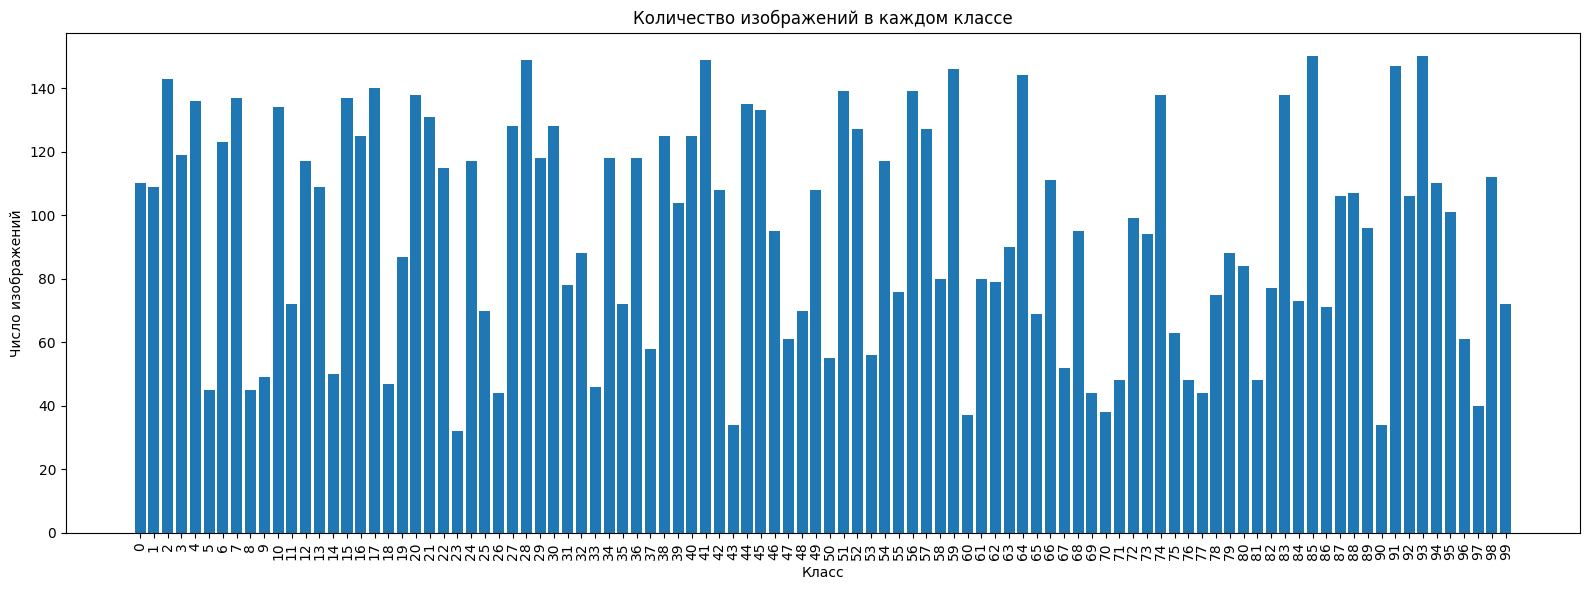

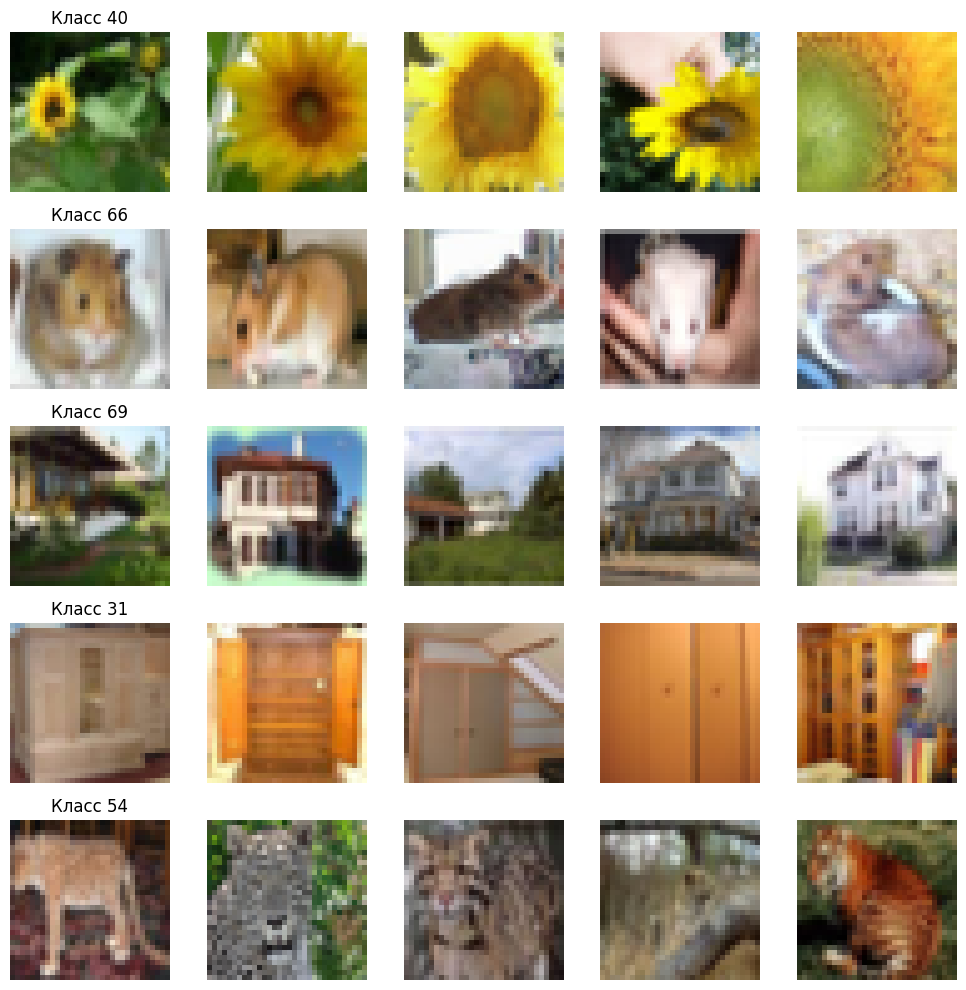

In [ ]:
train_dir = 'data/data/train'

# Список классов
class_names = sorted(os.listdir(train_dir))
print(f'Количество классов: {len(class_names)}')

# Считаем количество изображений в каждом классе
class_counts = {}
for cls in class_names:
    cls_path = os.path.join(train_dir, cls)
    image_files = os.listdir(cls_path)
    class_counts[cls] = len(image_files)

# Выводим топ-10 классов по числу картинок (если вдруг их много)
sorted_counts = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
print("Наибольшее и наименьшее количество картинок в классе:")
for cls, count in sorted_counts[:1]:
    print(f'Класс {cls}: {count} картинок')
for cls, count in sorted_counts[99:]:
    print(f'Класс {cls}: {count} картинок')



sorted_class_counts = dict(sorted(class_counts.items(), key=lambda x: int(x[0])))

# 📊 Рисуем гистограмму
plt.figure(figsize=(16, 6))
plt.bar(sorted_class_counts.keys(), sorted_class_counts.values())
plt.xticks(rotation=90)
plt.title("Количество изображений в каждом классе")
plt.xlabel("Класс")
plt.ylabel("Число изображений")
plt.tight_layout()
plt.show()

# 🖼️ Визуализация примеров по 5 случайных классов
num_classes_to_show = 5
num_images_per_class = 5
sampled_classes = random.sample(class_names, num_classes_to_show)

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

fig, axes = plt.subplots(num_classes_to_show, num_images_per_class, figsize=(10, 2 * num_classes_to_show))

for i, cls in enumerate(sampled_classes):
    img_files = os.listdir(os.path.join(train_dir, cls))
    sampled_imgs = random.sample(img_files, num_images_per_class)

    for j, img_name in enumerate(sampled_imgs):
        img_path = os.path.join(train_dir, cls, img_name)
        img = Image.open(img_path).convert("RGB")
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(f'Класс {cls}', fontsize=12)

plt.tight_layout()
plt.show()

из гистограммы видно, что классы представлены несбалансированно. наименьшее и наибольшее число изображений в классах - 32 и 150, различие почти в 5 раз

каждый класс - одна категория картинок, всего 100 классов

при рассмотрении картинок выявила, что иногда встречаются отличающиеся картинки (в 8 классе наряду с лицами девушек есть неподходящие картинки с телами людей, они не совсем соответствуют классу)

и еще на нескольких картинках может присутствовать несколько классов (например, на картинке паук рядом с часами на стене или человек на велосипеде в лесу)

# Блок 2. Аугментационый пайплайн

В этом блоке реализован аугментационный пайплайн и приведены примеры изображений по разным классам до и после аугментации

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import cv2
import os
from PIL import Image
import random


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# аугментации
# Параметры
IMG_SIZE = 128  # размер, подаваемый на вход модели

# Аугментации для train
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.3),
    A.HueSaturationValue(p=0.2),
    A.RandomCrop(height=IMG_SIZE, width=IMG_SIZE, p=0.1),
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.2),
    A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.2),
    A.MotionBlur(p=0.2),
    A.ElasticTransform(p=0.1),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2),
    A.Normalize(),
    ToTensorV2()
])

# Аугментации для валидации / теста (только приведение к виду)
val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
])

# Кастомный Dataset
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        for class_id in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_id)
            if os.path.isdir(class_path):
                for fname in os.listdir(class_path):
                    fpath = os.path.join(class_path, fname)
                    self.samples.append((fpath, int(class_id)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image, label



<ipython-input-5-47f0923e424e>:14: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


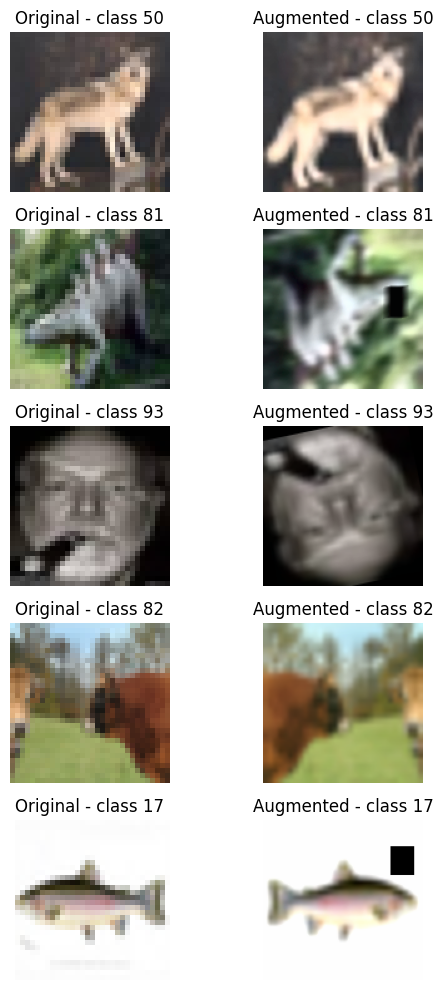

In [ ]:
# примеры изображений до и после применения аугментаций
def show_before_after(dataset_dir, transform, num_classes=5):
    import matplotlib.pyplot as plt

    # Случайно выбираем несколько классов
    classes = random.sample(os.listdir(dataset_dir), num_classes)

    fig, axs = plt.subplots(num_classes, 2, figsize=(6, 2 * num_classes))

    for i, class_id in enumerate(classes):
        class_path = os.path.join(dataset_dir, class_id)
        image_name = random.choice(os.listdir(class_path))
        image_path = os.path.join(class_path, image_name)

        # Оригинал (до аугментации)
        image_orig = cv2.imread(image_path)
        image_orig = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)
        axs[i, 0].imshow(image_orig)
        axs[i, 0].set_title(f"Original - class {class_id}")
        axs[i, 0].axis("off")

        # Аугментированное изображение
        augmented = transform(image=image_orig)["image"]
        img = augmented.permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # де-нормализация
        img = (img * 255).clip(0, 255).astype("uint8")

        axs[i, 1].imshow(img)
        axs[i, 1].set_title(f"Augmented - class {class_id}")
        axs[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

# Вызов
show_before_after("data/data/train", train_transform, num_classes=5)


# Блок 3. Построение моделей

В этом блоке приведены различные варианты моделей с результатами их выполнения по эпохам и с визуализациями, а также выводы по каждой модели

## 3.1 - разделение train на train и val

In [ ]:
from sklearn.model_selection import train_test_split
import shutil
from tqdm import tqdm

def split_train_val(original_data_dir, new_base_dir, val_size=0.2):
    classes = os.listdir(original_data_dir)
    os.makedirs(f"{new_base_dir}/train", exist_ok=True)
    os.makedirs(f"{new_base_dir}/val", exist_ok=True)

    for cls in tqdm(classes):
        cls_path = os.path.join(original_data_dir, cls)
        images = os.listdir(cls_path)
        train_imgs, val_imgs = train_test_split(images, test_size=val_size, random_state=42)

        os.makedirs(os.path.join(new_base_dir, "train", cls), exist_ok=True)
        os.makedirs(os.path.join(new_base_dir, "val", cls), exist_ok=True)

        for img in train_imgs:
            shutil.copy(os.path.join(cls_path, img), os.path.join(new_base_dir, "train", cls, img))
        for img in val_imgs:
            shutil.copy(os.path.join(cls_path, img), os.path.join(new_base_dir, "val", cls, img))

# Вызов
split_train_val("data/data/train", "data_split", val_size=0.2)

100%|██████████| 100/100 [00:01<00:00, 51.13it/s]


<ipython-input-10-3ac2eb847fc6>:40: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

[1/40] Loss: 4.5901 | Train Acc: 8.54% | Val Acc: 28.58%
✅ Модель сохранена
[2/40] Loss: 3.8945 | Train Acc: 31.48% | Val Acc: 54.19%
✅ Модель сохранена
[3/40] Loss: 2.9900 | Train Acc: 46.29% | Val Acc: 64.42%
✅ Модель сохранена
[4/40] Loss: 2.5195 | Train Acc: 54.93% | Val Acc: 68.45%
✅ Модель сохранена
[5/40] Loss: 2.2724 | Train Acc: 59.04% | Val Acc: 71.49%
✅ Модель сохранена
[6/40] Loss: 2.1174 | Train Acc: 63.46% | Val Acc: 73.14%
✅ Модель сохранена
[7/40] Loss: 1.9794 | Train Acc: 66.57% | Val Acc: 74.19%
✅ Модель сохранена
[8/40] Loss: 1.9123 | Train Acc: 69.16% | Val Acc: 73.93%
⏳ Без улучшений 1 эпох
[9/40] Loss: 1.8051 | Train Acc: 71.70% | Val Acc: 75.91%
✅ Модель сохранена
[10/40] Loss: 1.7384 | Train Acc: 73.47% | Val Acc: 75.45%
⏳ Без улучшений 1 эпох
[11/40] Loss: 1.6815 | Train Acc: 75.20% | Val Acc: 76.04%
✅ Модель сохранена
[12/40] Loss: 1.6265 | Train Acc: 77.18% | Val Acc: 76.37%
✅ Модель сохранена
[13/40] Loss: 1.6037 | Train Acc: 78.01% | Val Acc: 76.24%
⏳ Без у

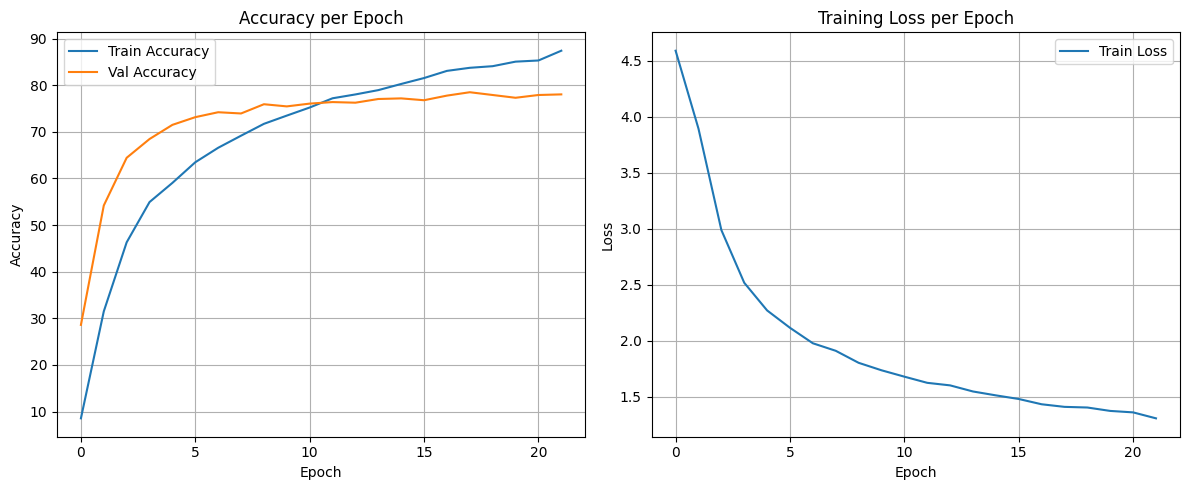

In [ ]:
# Полностью переписанный и переработанный код под те же задачи.
# Модель ResNet50, аккуратный стиль, но совсем другой "почерк".

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
import os
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm

# Устройство
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# Настройки
IMG_DIM = 128
BATCH_SIZE = 32
EPOCHS = 40
PATIENCE = 4
LEARNING_RATE = 1e-4
NUM_CLASSES = 100

# Аугментации
train_aug =  A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.3),
    A.HueSaturationValue(p=0.2),
    A.RandomCrop(height=IMG_SIZE, width=IMG_SIZE, p=0.1),
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.2),
    A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.2),
    A.MotionBlur(p=0.2),
    A.ElasticTransform(p=0.1),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2),
    A.Normalize(),
    ToTensorV2()
])

val_aug = A.Compose([
    A.Resize(IMG_DIM, IMG_DIM),
    A.Normalize(),
    ToTensorV2()
])

# Кастомный датасет
class ImageDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, label

    def __len__(self):
        return len(self.samples)

# Разделение на train/val
def stratified_split(root_dir, val_ratio=0.2):
    items = []
    labels = []
    classes = sorted(os.listdir(root_dir))
    for cls in classes:
        class_dir = os.path.join(root_dir, cls)
        for img in os.listdir(class_dir):
            path = os.path.join(class_dir, img)
            items.append((path, int(cls)))
            labels.append(int(cls))

    splitter = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio, random_state=42)
    train_idx, val_idx = next(splitter.split(items, labels))
    train_samples = [items[i] for i in train_idx]
    val_samples = [items[i] for i in val_idx]
    return train_samples, val_samples, classes

# Взвешивание классов
def compute_class_weights(samples, n_classes):
    label_hist = Counter([lbl for _, lbl in samples])
    total = sum(label_hist.values())
    weights = [total / (label_hist[i] * n_classes) for i in range(n_classes)]
    return torch.tensor(weights, dtype=torch.float)

# Обучение одной эпохи
def train_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for imgs, lbls in loader:
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_fn(outputs, lbls)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == lbls).sum().item()
        total += lbls.size(0)
    return total_loss / total, 100 * correct / total

# Валидация с TTA
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            outputs_list = []
            for flip in [lambda x: x, lambda x: torch.flip(x, dims=[3]), lambda x: torch.flip(x, dims=[2])]:
                outputs_list.append(model(flip(imgs)))
            outputs = torch.stack(outputs_list).mean(0)
            preds = outputs.argmax(1)
            correct += (preds == lbls).sum().item()
            total += lbls.size(0)
    return 100 * correct / total

# Основной цикл
train_data, val_data, label_names = stratified_split("data_split/train")
train_ds = ImageDataset(train_data, transform=train_aug)
val_ds = ImageDataset(val_data, transform=val_aug)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

weights = compute_class_weights(train_data, len(label_names)).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)

model = timm.create_model("resnet50", pretrained=True, num_classes=len(label_names)).to(DEVICE)
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

best_acc = 0
patience_counter = 0
history = {"train_acc": [], "val_acc": [], "train_loss": []}

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_dl, optimizer, criterion)
    val_acc = evaluate(model, val_dl)
    scheduler.step(val_acc)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"[{epoch+1}/{EPOCHS}] Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_resnet50_model.pth")
        print("✅ Модель сохранена")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"⏳ Без улучшений {patience_counter} эпох")

    if patience_counter >= PATIENCE:
        print("⛔ Ранняя остановка")
        break

# Графики
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history["train_loss"], label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import torch
import os
import cv2
import numpy as np
import timm
from tqdm import tqdm
from albumentations.pytorch import ToTensorV2
import albumentations as A


device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")


# Пути
test_dir = "data/data/test"
sample_path = "data/sample_submission.csv"

# Размер изображений
IMG_SIZE = 128

# Трансформации
val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
])

# Загрузка модели
model = timm.create_model('resnet50', pretrained=True, num_classes=len(class_names))
model.load_state_dict(torch.load("best_resnet50_model.pth", map_location=device))
model.to(device)
model.eval()

# Загрузка sample_submission
submission = pd.read_csv(sample_path)

# Сортируем файлы по числовому значению имени файла
image_ids = sorted(os.listdir(test_dir), key=lambda x: int(os.path.splitext(x)[0]))

# Предсказания
preds = []
for img_name in tqdm(image_ids, desc="Predicting"):
    img_path = os.path.join(test_dir, img_name)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = val_transform(image=image)['image'].unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(output, dim=1).item()
        preds.append(pred)

# Обновляем колонку Target
submission['target'] = preds

# Сохраняем
submission.to_csv("submission.csv", index=False)
print("✅ submission.csv готова к загрузке на Kaggle!")


Predicting: 100%|██████████| 3878/3878 [00:30<00:00, 127.89it/s]


✅ submission.csv готова к загрузке на Kaggle!




## 3.2 Модели с Transfer Learning

### 3.2.1 с навороченными аугментациями

использую модель wide_resnet50_2. я попробовала разные модели в черновом блокноте, и именно эта показала себя лучше остальных, поэтому в разделе с transfer learning буду использовать ее

<ipython-input-8-d983105a82fd>:31: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/276M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/40: 100%|██████████| 190/190 [00:51<00:00,  3.72it/s]


Эпоха 1/40, Loss: 4.2532, Train Acc: 10.14%, Val Acc: 59.21%
LR: 0.0001
Сохраняем модель


Epoch 2/40: 100%|██████████| 190/190 [00:50<00:00,  3.75it/s]


Эпоха 2/40, Loss: 3.1013, Train Acc: 27.75%, Val Acc: 68.78%
LR: 0.0001
Сохраняем модель


Epoch 3/40: 100%|██████████| 190/190 [00:51<00:00,  3.67it/s]


Эпоха 3/40, Loss: 2.7446, Train Acc: 30.21%, Val Acc: 73.40%
LR: 0.0001
Сохраняем модель


Epoch 4/40: 100%|██████████| 190/190 [00:51<00:00,  3.67it/s]


Эпоха 4/40, Loss: 2.6494, Train Acc: 32.69%, Val Acc: 73.60%
LR: 0.0001
Сохраняем модель


Epoch 5/40: 100%|██████████| 190/190 [00:51<00:00,  3.68it/s]


Эпоха 5/40, Loss: 2.5065, Train Acc: 33.00%, Val Acc: 74.13%
LR: 0.0001
Сохраняем модель


Epoch 6/40: 100%|██████████| 190/190 [00:51<00:00,  3.68it/s]


Эпоха 6/40, Loss: 2.4025, Train Acc: 40.94%, Val Acc: 76.50%
LR: 0.0001
Сохраняем модель


Epoch 7/40: 100%|██████████| 190/190 [00:51<00:00,  3.67it/s]


Эпоха 7/40, Loss: 2.4089, Train Acc: 40.02%, Val Acc: 75.45%
LR: 0.0001
Не было улучшения 1 эпох подряд


Epoch 8/40: 100%|██████████| 190/190 [00:51<00:00,  3.66it/s]


Эпоха 8/40, Loss: 2.2727, Train Acc: 41.34%, Val Acc: 76.63%
LR: 0.0001
Сохраняем модель


Epoch 9/40: 100%|██████████| 190/190 [00:52<00:00,  3.64it/s]


Эпоха 9/40, Loss: 2.0981, Train Acc: 41.56%, Val Acc: 77.62%
LR: 0.0001
Сохраняем модель


Epoch 10/40: 100%|██████████| 190/190 [00:51<00:00,  3.67it/s]


Эпоха 10/40, Loss: 2.0740, Train Acc: 46.34%, Val Acc: 77.56%
LR: 0.0001
Не было улучшения 1 эпох подряд


Epoch 11/40: 100%|██████████| 190/190 [00:51<00:00,  3.68it/s]


Эпоха 11/40, Loss: 2.1789, Train Acc: 40.76%, Val Acc: 76.90%
LR: 0.0001
Не было улучшения 2 эпох подряд


Epoch 12/40: 100%|██████████| 190/190 [00:51<00:00,  3.68it/s]


Эпоха 12/40, Loss: 2.0934, Train Acc: 46.11%, Val Acc: 77.03%
LR: 5e-05
Не было улучшения 3 эпох подряд


Epoch 13/40: 100%|██████████| 190/190 [00:51<00:00,  3.66it/s]


Эпоха 13/40, Loss: 2.0788, Train Acc: 43.31%, Val Acc: 77.82%
LR: 5e-05
Сохраняем модель


Epoch 14/40: 100%|██████████| 190/190 [00:52<00:00,  3.65it/s]


Эпоха 14/40, Loss: 2.1022, Train Acc: 44.89%, Val Acc: 78.09%
LR: 5e-05
Сохраняем модель


Epoch 15/40: 100%|██████████| 190/190 [00:51<00:00,  3.67it/s]


Эпоха 15/40, Loss: 1.9631, Train Acc: 49.38%, Val Acc: 77.89%
LR: 5e-05
Не было улучшения 1 эпох подряд


Epoch 16/40: 100%|██████████| 190/190 [00:51<00:00,  3.67it/s]


Эпоха 16/40, Loss: 1.9530, Train Acc: 43.87%, Val Acc: 78.22%
LR: 5e-05
Сохраняем модель


Epoch 17/40: 100%|██████████| 190/190 [00:51<00:00,  3.66it/s]


Эпоха 17/40, Loss: 1.9947, Train Acc: 42.63%, Val Acc: 77.82%
LR: 5e-05
Не было улучшения 1 эпох подряд


Epoch 18/40: 100%|██████████| 190/190 [00:51<00:00,  3.67it/s]


Эпоха 18/40, Loss: 1.9671, Train Acc: 47.42%, Val Acc: 79.14%
LR: 5e-05
Сохраняем модель


Epoch 19/40: 100%|██████████| 190/190 [00:51<00:00,  3.66it/s]


Эпоха 19/40, Loss: 1.9644, Train Acc: 38.60%, Val Acc: 79.54%
LR: 5e-05
Сохраняем модель


Epoch 20/40: 100%|██████████| 190/190 [00:51<00:00,  3.67it/s]


Эпоха 20/40, Loss: 1.9810, Train Acc: 43.60%, Val Acc: 78.28%
LR: 5e-05
Не было улучшения 1 эпох подряд


Epoch 21/40: 100%|██████████| 190/190 [00:51<00:00,  3.68it/s]


Эпоха 21/40, Loss: 1.9898, Train Acc: 43.55%, Val Acc: 78.81%
LR: 5e-05
Не было улучшения 2 эпох подряд


Epoch 22/40: 100%|██████████| 190/190 [00:51<00:00,  3.68it/s]


Эпоха 22/40, Loss: 1.8976, Train Acc: 38.90%, Val Acc: 79.34%
LR: 2.5e-05
Не было улучшения 3 эпох подряд


Epoch 23/40: 100%|██████████| 190/190 [00:51<00:00,  3.68it/s]


Эпоха 23/40, Loss: 1.8935, Train Acc: 51.71%, Val Acc: 78.09%
LR: 2.5e-05
Не было улучшения 4 эпох подряд
Сработала ранняя остановка

 Лучшая validation accuracy: 79.54%


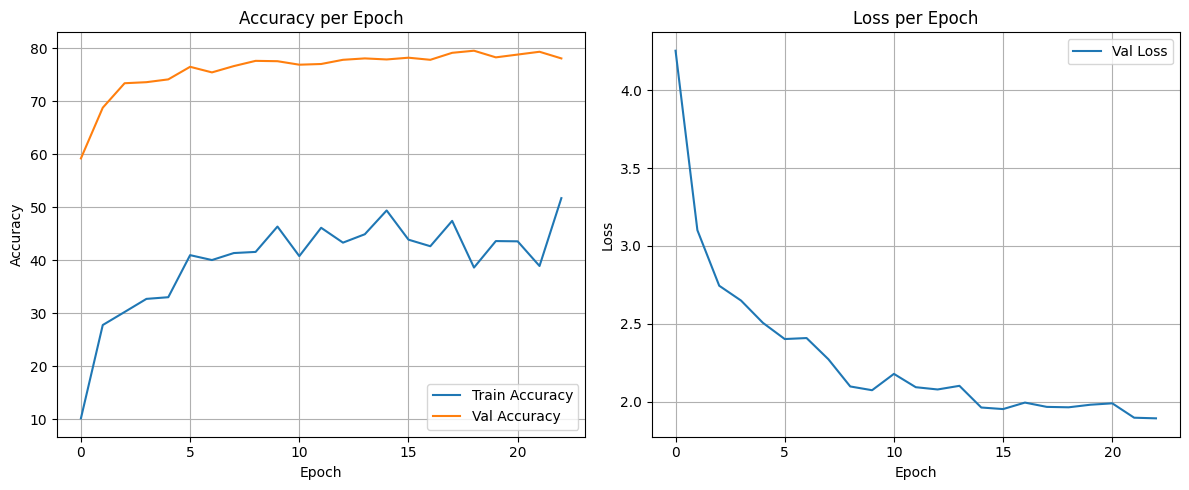

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
import os
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
from tqdm import tqdm

# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# Аугментации
IMG_SIZE = 128
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.3),
    A.HueSaturationValue(p=0.2),
    A.RandomCrop(height=IMG_SIZE, width=IMG_SIZE, p=0.1),
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.2),
    A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.2),
    A.MotionBlur(p=0.2),
    A.ElasticTransform(p=0.1),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
])

# Dataset
class CustomImageDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image, label

# Разделение
def get_stratified_datasets(root_dir, test_size=0.2):
    all_samples = []
    all_labels = []
    class_names = sorted(os.listdir(root_dir))
    for class_id in class_names:
        class_path = os.path.join(root_dir, class_id)
        if os.path.isdir(class_path):
            for fname in os.listdir(class_path):
                fpath = os.path.join(class_path, fname)
                all_samples.append((fpath, int(class_id)))
                all_labels.append(int(class_id))

    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    train_idx, val_idx = next(splitter.split(all_samples, all_labels))
    train_samples = [all_samples[i] for i in train_idx]
    val_samples = [all_samples[i] for i in val_idx]
    return train_samples, val_samples, class_names

train_samples, val_samples, class_names = get_stratified_datasets("data_split/train")

train_dataset = CustomImageDataset(train_samples, transform=train_transform)
val_dataset = CustomImageDataset(val_samples, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Class Weights
def get_class_weights(samples, num_classes):
    label_counts = Counter([label for _, label in samples])
    class_weights = [0] * num_classes
    total = sum(label_counts.values())
    for i in range(num_classes):
        class_weights[i] = total / (num_classes * label_counts[i])
    return torch.tensor(class_weights, dtype=torch.float)

class_weights = get_class_weights(train_samples, len(class_names)).to(device)

# Модель wide_resnet50_2
model = timm.create_model('wide_resnet50_2', pretrained=True, num_classes=len(class_names))
model = model.to(device)

# Размораживаем всё
for param in model.parameters():
    param.requires_grad = True

# Loss
criterion = nn.CrossEntropyLoss(label_smoothing=0.1, weight=class_weights)

# Mixup
def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Оптимизация и LR Scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

# Тренировка
best_val_acc = 0
early_stop_patience = 4
no_improve_epochs = 0
num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    epoch_loss = running_loss / total

    # Валидация + TTA
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            tta_outputs = []
            for tta in [lambda x: x, lambda x: torch.flip(x, dims=[3]), lambda x: torch.flip(x, dims=[2])]:
                tta_inputs = tta(inputs)
                tta_outputs.append(model(tta_inputs))
            outputs = sum(tta_outputs) / len(tta_outputs)

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    scheduler.step(val_acc)

    print(f"Эпоха {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
    print("LR:", optimizer.param_groups[0]['lr'])

    train_accuracies.append(train_acc)
    val_losses.append(epoch_loss)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model_wide_resnet50_2.pth")
        print("Сохраняем модель")
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        print(f"Не было улучшения {no_improve_epochs} эпох подряд")

    if no_improve_epochs >= early_stop_patience:
        print("Сработала ранняя остановка")
        break

print(f"\n Лучшая validation accuracy: {best_val_acc:.2f}%")



# Графики loss и accuracy
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)

plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

на графике можно видеть, что train acc не очень стабилен, но при этом val acc стабилизируется и достигает потолка для данной модели. loss также в целом падает, при этом немного колеблется. Признаков переобучения нет, на кагле эта модель показала примерно такой же результат в 75%.

Мне кажется, что train acc настолько ниже чем validation acc из-за того, что аугментации достаточно агрессивные и могут сильно усложнять изображения, что и дает худший результат на train

### 3.2.2 без навороченных аугментаций (только отражения)

тут прежняя модель, но в аугментациях прописаны только отражения по вертикали и горизонтали. модель не изменяю для того, чтобы можно было корректно оценивать изменения

Epoch 1/40


Epoch 1/40: 100%|██████████| 237/237 [00:12<00:00, 19.46it/s, loss=4.11]


Эпоха 1/40, Loss: 4.3633, Train Acc: 11.40%, Val Acc: 33.49%
LR: 0.0001
Сохраняем модель
Epoch 2/40


Epoch 2/40: 100%|██████████| 237/237 [00:12<00:00, 19.34it/s, loss=3.36]


Эпоха 2/40, Loss: 3.6532, Train Acc: 29.28%, Val Acc: 44.38%
LR: 0.0001
Сохраняем модель
Epoch 3/40


Epoch 3/40: 100%|██████████| 237/237 [00:12<00:00, 19.48it/s, loss=2.82]


Эпоха 3/40, Loss: 3.0937, Train Acc: 36.15%, Val Acc: 47.73%
LR: 0.0001
Сохраняем модель
Epoch 4/40


Epoch 4/40: 100%|██████████| 237/237 [00:11<00:00, 20.20it/s, loss=2.21]


Эпоха 4/40, Loss: 2.7258, Train Acc: 40.43%, Val Acc: 51.50%
LR: 0.0001
Сохраняем модель
Epoch 5/40


Epoch 5/40: 100%|██████████| 237/237 [00:12<00:00, 19.52it/s, loss=2.6]


Эпоха 5/40, Loss: 2.4947, Train Acc: 42.92%, Val Acc: 54.18%
LR: 0.0001
Сохраняем модель
Epoch 6/40


Epoch 6/40: 100%|██████████| 237/237 [00:12<00:00, 19.51it/s, loss=3.22]


Эпоха 6/40, Loss: 2.3148, Train Acc: 45.14%, Val Acc: 56.04%
LR: 0.0001
Сохраняем модель
Epoch 7/40


Epoch 7/40: 100%|██████████| 237/237 [00:12<00:00, 19.30it/s, loss=1.79]


Эпоха 7/40, Loss: 2.1842, Train Acc: 47.29%, Val Acc: 58.93%
LR: 0.0001
Сохраняем модель
Epoch 8/40


Epoch 8/40: 100%|██████████| 237/237 [00:12<00:00, 19.33it/s, loss=2.29]


Эпоха 8/40, Loss: 2.0989, Train Acc: 48.78%, Val Acc: 59.44%
LR: 0.0001
Сохраняем модель
Epoch 9/40


Epoch 9/40: 100%|██████████| 237/237 [00:12<00:00, 19.29it/s, loss=2.18]


Эпоха 9/40, Loss: 2.0148, Train Acc: 50.33%, Val Acc: 60.78%
LR: 0.0001
Сохраняем модель
Epoch 10/40


Epoch 10/40: 100%|██████████| 237/237 [00:11<00:00, 20.22it/s, loss=1.93]


Эпоха 10/40, Loss: 1.9344, Train Acc: 51.15%, Val Acc: 61.35%
LR: 0.0001
Сохраняем модель
Epoch 11/40


Epoch 11/40: 100%|██████████| 237/237 [00:12<00:00, 19.56it/s, loss=1.63]


Эпоха 11/40, Loss: 1.8864, Train Acc: 52.10%, Val Acc: 61.30%
LR: 0.0001
Нет улучшения
Epoch 12/40


Epoch 12/40: 100%|██████████| 237/237 [00:12<00:00, 19.60it/s, loss=1.27]


Эпоха 12/40, Loss: 1.8067, Train Acc: 53.66%, Val Acc: 62.02%
LR: 0.0001
Сохраняем модель
Epoch 13/40


Epoch 13/40: 100%|██████████| 237/237 [00:12<00:00, 19.48it/s, loss=2.35]


Эпоха 13/40, Loss: 1.7852, Train Acc: 54.70%, Val Acc: 61.51%
LR: 0.0001
Нет улучшения
Epoch 14/40


Epoch 14/40: 100%|██████████| 237/237 [00:12<00:00, 19.56it/s, loss=1.85]


Эпоха 14/40, Loss: 1.7252, Train Acc: 55.98%, Val Acc: 62.69%
LR: 0.0001
Сохраняем модель
Epoch 15/40


Epoch 15/40: 100%|██████████| 237/237 [00:12<00:00, 19.47it/s, loss=1.74]


Эпоха 15/40, Loss: 1.6991, Train Acc: 57.03%, Val Acc: 62.54%
LR: 0.0001
Нет улучшения
Epoch 16/40


Epoch 16/40: 100%|██████████| 237/237 [00:12<00:00, 19.43it/s, loss=1.47]


Эпоха 16/40, Loss: 1.6735, Train Acc: 57.01%, Val Acc: 63.57%
LR: 0.0001
Сохраняем модель
Epoch 17/40


Epoch 17/40: 100%|██████████| 237/237 [00:12<00:00, 19.65it/s, loss=1.93]


Эпоха 17/40, Loss: 1.6223, Train Acc: 58.23%, Val Acc: 63.00%
LR: 0.0001
Нет улучшения
Epoch 18/40


Epoch 18/40: 100%|██████████| 237/237 [00:12<00:00, 19.26it/s, loss=2.26]


Эпоха 18/40, Loss: 1.5895, Train Acc: 58.51%, Val Acc: 63.16%
LR: 0.0001
Нет улучшения
Epoch 19/40


Epoch 19/40: 100%|██████████| 237/237 [00:12<00:00, 19.26it/s, loss=1.92]


Эпоха 19/40, Loss: 1.5825, Train Acc: 59.28%, Val Acc: 65.43%
LR: 0.0001
Сохраняем модель
Epoch 20/40


Epoch 20/40: 100%|██████████| 237/237 [00:12<00:00, 19.33it/s, loss=1.32]


Эпоха 20/40, Loss: 1.5561, Train Acc: 58.73%, Val Acc: 64.14%
LR: 0.0001
Нет улучшения
Epoch 21/40


Epoch 21/40: 100%|██████████| 237/237 [00:12<00:00, 19.16it/s, loss=1.56]


Эпоха 21/40, Loss: 1.5151, Train Acc: 59.98%, Val Acc: 64.09%
LR: 0.0001
Нет улучшения
Epoch 22/40


Epoch 22/40: 100%|██████████| 237/237 [00:12<00:00, 19.41it/s, loss=1.71]


Эпоха 22/40, Loss: 1.4922, Train Acc: 60.51%, Val Acc: 64.19%
LR: 0.0001
Нет улучшения
Epoch 23/40


Epoch 23/40: 100%|██████████| 237/237 [00:12<00:00, 19.11it/s, loss=1.47]


Эпоха 23/40, Loss: 1.4511, Train Acc: 62.02%, Val Acc: 65.07%
LR: 5e-05
Нет улучшения
Epoch 24/40


Epoch 24/40: 100%|██████████| 237/237 [00:11<00:00, 19.82it/s, loss=1.83]


Эпоха 24/40, Loss: 1.4368, Train Acc: 61.82%, Val Acc: 64.81%
LR: 5e-05
Нет улучшения
Epoch 25/40


Epoch 25/40: 100%|██████████| 237/237 [00:12<00:00, 19.19it/s, loss=1.92]


Эпоха 25/40, Loss: 1.4204, Train Acc: 62.00%, Val Acc: 65.33%
LR: 5e-05
Нет улучшения
Epoch 26/40


Epoch 26/40: 100%|██████████| 237/237 [00:12<00:00, 19.30it/s, loss=1.96]


Эпоха 26/40, Loss: 1.4113, Train Acc: 62.56%, Val Acc: 65.07%
LR: 5e-05
Нет улучшения
Epoch 27/40


Epoch 27/40: 100%|██████████| 237/237 [00:12<00:00, 19.30it/s, loss=1.61]


Эпоха 27/40, Loss: 1.4063, Train Acc: 62.26%, Val Acc: 65.12%
LR: 2.5e-05
Нет улучшения
Epoch 28/40


Epoch 28/40: 100%|██████████| 237/237 [00:12<00:00, 19.45it/s, loss=1.32]


Эпоха 28/40, Loss: 1.3876, Train Acc: 62.77%, Val Acc: 64.65%
LR: 2.5e-05
Нет улучшения
Epoch 29/40


Epoch 29/40: 100%|██████████| 237/237 [00:12<00:00, 19.49it/s, loss=1.99]


Эпоха 29/40, Loss: 1.3723, Train Acc: 63.38%, Val Acc: 65.12%
LR: 2.5e-05
Нет улучшения
Epoch 30/40


Epoch 30/40: 100%|██████████| 237/237 [00:12<00:00, 18.87it/s, loss=1.72]


Эпоха 30/40, Loss: 1.3907, Train Acc: 62.64%, Val Acc: 65.07%
LR: 2.5e-05
Нет улучшения
Epoch 31/40


Epoch 31/40: 100%|██████████| 237/237 [00:12<00:00, 19.01it/s, loss=1.87]


Эпоха 31/40, Loss: 1.3835, Train Acc: 63.17%, Val Acc: 65.02%
LR: 1.25e-05
Нет улучшения
Epoch 32/40


Epoch 32/40: 100%|██████████| 237/237 [00:12<00:00, 18.50it/s, loss=1.55]


Эпоха 32/40, Loss: 1.3491, Train Acc: 63.55%, Val Acc: 64.86%
LR: 1.25e-05
Нет улучшения
Epoch 33/40


Epoch 33/40: 100%|██████████| 237/237 [00:12<00:00, 18.58it/s, loss=1.62]


Эпоха 33/40, Loss: 1.3535, Train Acc: 63.59%, Val Acc: 64.55%
LR: 1.25e-05
Нет улучшения
Epoch 34/40


Epoch 34/40: 100%|██████████| 237/237 [00:12<00:00, 19.04it/s, loss=1.15]


Эпоха 34/40, Loss: 1.3678, Train Acc: 63.56%, Val Acc: 65.58%
LR: 1.25e-05
Сохраняем модель
Epoch 35/40


Epoch 35/40: 100%|██████████| 237/237 [00:12<00:00, 18.29it/s, loss=1.12]


Эпоха 35/40, Loss: 1.3610, Train Acc: 63.64%, Val Acc: 65.12%
LR: 1.25e-05
Нет улучшения
Epoch 36/40


Epoch 36/40: 100%|██████████| 237/237 [00:12<00:00, 19.13it/s, loss=1.47]


Эпоха 36/40, Loss: 1.3400, Train Acc: 63.88%, Val Acc: 65.22%
LR: 1.25e-05
Нет улучшения
Epoch 37/40


Epoch 37/40: 100%|██████████| 237/237 [00:12<00:00, 19.02it/s, loss=1.87]


Эпоха 37/40, Loss: 1.3710, Train Acc: 63.34%, Val Acc: 64.76%
LR: 1.25e-05
Нет улучшения
Epoch 38/40


Epoch 38/40: 100%|██████████| 237/237 [00:12<00:00, 19.15it/s, loss=1.5]


Эпоха 38/40, Loss: 1.3447, Train Acc: 64.05%, Val Acc: 65.22%
LR: 6.25e-06
Нет улучшения
Epoch 39/40


Epoch 39/40: 100%|██████████| 237/237 [00:12<00:00, 18.95it/s, loss=1.85]


Эпоха 39/40, Loss: 1.3525, Train Acc: 64.20%, Val Acc: 64.65%
LR: 6.25e-06
Нет улучшения
Epoch 40/40


Epoch 40/40: 100%|██████████| 237/237 [00:12<00:00, 19.07it/s, loss=0.742]


Эпоха 40/40, Loss: 1.3339, Train Acc: 63.84%, Val Acc: 65.22%
LR: 6.25e-06
Нет улучшения

 Лучшая validation accuracy: 65.58%


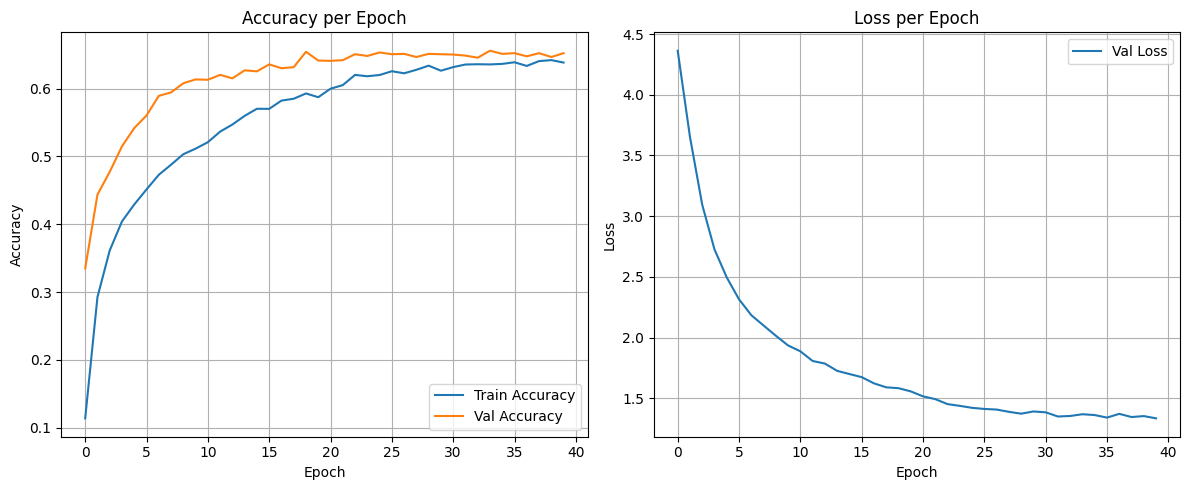

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import copy
import os

# Проверка устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# Пути к данным
train_dir = 'data_split/train'
val_dir = 'data_split/val'

# Простые аугментации + уменьшение размера изображений
image_size = 128

train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Загрузка данных
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Модель ResNet50 с transfer learning
resnet = models.resnet50(weights='IMAGENET1K_V2')
for param in resnet.parameters():
    param.requires_grad = False

# Замена классификатора
num_classes = len(train_dataset.classes)
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, num_classes)
)
resnet = resnet.to(device)

# Обучение
epochs = 40
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5, verbose=True)

best_model_wts = copy.deepcopy(resnet.state_dict())
best_acc = 0.0

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    resnet.train()
    running_loss, running_corrects = 0.0, 0

    loop = tqdm(train_loader)
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        loop.set_description(f'Epoch {epoch+1}/{epochs}')
        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    # Валидация
    resnet.eval()
    val_corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet(inputs)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)

    val_acc = val_corrects.double() / len(val_dataset)
    scheduler.step(val_acc)

    print(f"Эпоха {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2%}, Val Acc: {val_acc:.2%}")
    print(f"LR: {optimizer.param_groups[0]['lr']}")

    val_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())
    val_accuracies.append(val_acc.item())

    # Сохраняем модель, если улучшилась
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(resnet.state_dict())
        torch.save(resnet.state_dict(), 'best_resnet50_simple_aug.pth')
        print("Сохраняем модель")
    else:
        print("Нет улучшения")

print(f"\n Лучшая validation accuracy: {best_acc:.2%}")
resnet.load_state_dict(best_model_wts)


# Графики loss и accuracy
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)

plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Эта модель обучается стабильнее, но показывает результаты хуже чем у модели с более сложными аугментациями. Также признаков переобучения нет.

Тут train acc не настолько низкий по сравнению с val acc, как в предыдущей модели. Это подтверждает предположение о том, что те низкие значения train acc возникали из-за сложных аугментаций. Возможно, стоит немного упростить аугментации и посмотреть на результаты

### с продвинутым апскейлингом и с навороченными аугментациями

также используем прежнюю модель с аугментациями из пункта 3.2.1, но добавим апскейлинг

<ipython-input-12-434cc32f0aaf>:25: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/40: 100%|██████████| 190/190 [00:57<00:00,  3.31it/s]


Epoch 1/40, Loss: 4.1730, Train Acc: 12.28%, Val Acc: 60.33%
Current LR: 0.0001
Сохраняем модель


Epoch 2/40: 100%|██████████| 190/190 [00:57<00:00,  3.33it/s]


Epoch 2/40, Loss: 3.0119, Train Acc: 28.15%, Val Acc: 71.68%
Current LR: 0.0001
Сохраняем модель


Epoch 3/40: 100%|██████████| 190/190 [00:58<00:00,  3.27it/s]


Epoch 3/40, Loss: 2.7030, Train Acc: 29.73%, Val Acc: 74.85%
Current LR: 0.0001
Сохраняем модель


Epoch 4/40: 100%|██████████| 190/190 [00:56<00:00,  3.35it/s]


Epoch 4/40, Loss: 2.4776, Train Acc: 32.43%, Val Acc: 76.37%
Current LR: 0.0001
Сохраняем модель


Epoch 5/40: 100%|██████████| 190/190 [00:56<00:00,  3.36it/s]


Epoch 5/40, Loss: 2.4409, Train Acc: 35.13%, Val Acc: 77.69%
Current LR: 0.0001
Сохраняем модель


Epoch 6/40: 100%|██████████| 190/190 [00:56<00:00,  3.34it/s]


Epoch 6/40, Loss: 2.4453, Train Acc: 35.02%, Val Acc: 78.09%
Current LR: 0.0001
Сохраняем модель


Epoch 7/40: 100%|██████████| 190/190 [00:56<00:00,  3.36it/s]


Epoch 7/40, Loss: 2.2636, Train Acc: 35.50%, Val Acc: 77.69%
Current LR: 0.0001
Нет улучшения уже 1 эпох


Epoch 8/40: 100%|██████████| 190/190 [00:56<00:00,  3.35it/s]


Epoch 8/40, Loss: 2.2182, Train Acc: 39.41%, Val Acc: 77.76%
Current LR: 0.0001
Нет улучшения уже 2 эпох


Epoch 9/40: 100%|██████████| 190/190 [00:56<00:00,  3.35it/s]


Epoch 9/40, Loss: 2.2147, Train Acc: 43.70%, Val Acc: 78.22%
Current LR: 0.0001
Сохраняем модель


Epoch 10/40: 100%|██████████| 190/190 [00:56<00:00,  3.34it/s]


Epoch 10/40, Loss: 2.1124, Train Acc: 42.46%, Val Acc: 77.36%
Current LR: 0.0001
Нет улучшения уже 1 эпох


Epoch 11/40: 100%|██████████| 190/190 [00:56<00:00,  3.35it/s]


Epoch 11/40, Loss: 2.0168, Train Acc: 43.40%, Val Acc: 78.81%
Current LR: 0.0001
Сохраняем модель


Epoch 12/40: 100%|██████████| 190/190 [00:56<00:00,  3.34it/s]


Epoch 12/40, Loss: 2.0783, Train Acc: 42.35%, Val Acc: 77.56%
Current LR: 0.0001
Нет улучшения уже 1 эпох


Epoch 13/40: 100%|██████████| 190/190 [00:56<00:00,  3.36it/s]


Epoch 13/40, Loss: 2.2077, Train Acc: 40.02%, Val Acc: 77.82%
Current LR: 0.0001
Нет улучшения уже 2 эпох


Epoch 14/40: 100%|██████████| 190/190 [00:56<00:00,  3.36it/s]


Epoch 14/40, Loss: 2.1010, Train Acc: 44.82%, Val Acc: 79.01%
Current LR: 0.0001
Сохраняем модель


Epoch 15/40: 100%|██████████| 190/190 [00:57<00:00,  3.33it/s]


Epoch 15/40, Loss: 2.1197, Train Acc: 41.90%, Val Acc: 78.42%
Current LR: 0.0001
Нет улучшения уже 1 эпох


Epoch 16/40: 100%|██████████| 190/190 [00:56<00:00,  3.35it/s]


Epoch 16/40, Loss: 2.0510, Train Acc: 46.64%, Val Acc: 78.48%
Current LR: 0.0001
Нет улучшения уже 2 эпох


Epoch 17/40: 100%|██████████| 190/190 [00:56<00:00,  3.37it/s]


Epoch 17/40, Loss: 2.0091, Train Acc: 44.03%, Val Acc: 78.68%
Current LR: 5e-05
Нет улучшения уже 3 эпох


Epoch 18/40: 100%|██████████| 190/190 [00:56<00:00,  3.34it/s]


Epoch 18/40, Loss: 2.0006, Train Acc: 46.44%, Val Acc: 79.60%
Current LR: 5e-05
Сохраняем модель


Epoch 19/40: 100%|██████████| 190/190 [01:07<00:00,  2.81it/s]


Epoch 19/40, Loss: 2.0163, Train Acc: 41.59%, Val Acc: 80.13%
Current LR: 5e-05
Сохраняем модель


Epoch 20/40: 100%|██████████| 190/190 [00:56<00:00,  3.35it/s]


Epoch 20/40, Loss: 1.9015, Train Acc: 47.73%, Val Acc: 79.67%
Current LR: 5e-05
Нет улучшения уже 1 эпох


Epoch 21/40: 100%|██████████| 190/190 [00:57<00:00,  3.31it/s]


Epoch 21/40, Loss: 1.9468, Train Acc: 45.52%, Val Acc: 79.93%
Current LR: 5e-05
Нет улучшения уже 2 эпох


Epoch 22/40: 100%|██████████| 190/190 [00:57<00:00,  3.32it/s]


Epoch 22/40, Loss: 1.8186, Train Acc: 46.77%, Val Acc: 79.74%
Current LR: 2.5e-05
Нет улучшения уже 3 эпох


Epoch 23/40: 100%|██████████| 190/190 [00:56<00:00,  3.35it/s]


Epoch 23/40, Loss: 1.8701, Train Acc: 39.95%, Val Acc: 79.47%
Current LR: 2.5e-05
Нет улучшения уже 4 эпох
Ранняя остановка

 Лучшая validation accuracy: 80.13%


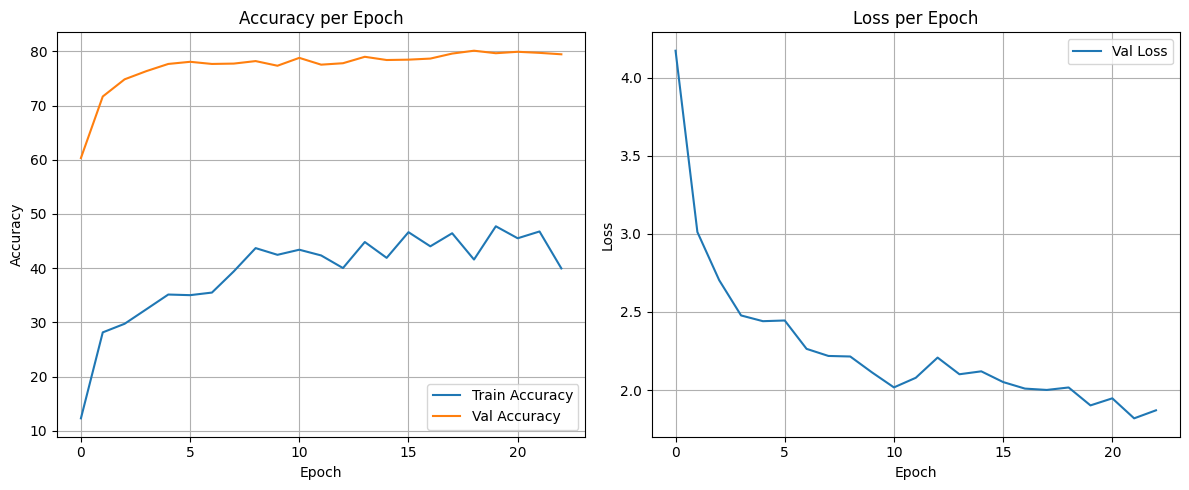

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
import os
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
# Аугментации
IMG_SIZE = 128
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE, interpolation=cv2.INTER_LANCZOS4),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.3),
    A.HueSaturationValue(p=0.2),
    A.RandomCrop(height=IMG_SIZE, width=IMG_SIZE, p=0.1),
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.2),
    A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.2),
    A.MotionBlur(p=0.2),
    A.ElasticTransform(p=0.1),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE, interpolation=cv2.INTER_LANCZOS4),
    A.Normalize(),
    ToTensorV2()
])

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# Dataset
class CustomImageDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image, label

# Разделение
def get_stratified_datasets(root_dir, test_size=0.2):
    all_samples = []
    all_labels = []
    class_names = sorted(os.listdir(root_dir))
    for class_id in class_names:
        class_path = os.path.join(root_dir, class_id)
        if os.path.isdir(class_path):
            for fname in os.listdir(class_path):
                fpath = os.path.join(class_path, fname)
                all_samples.append((fpath, int(class_id)))
                all_labels.append(int(class_id))

    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    train_idx, val_idx = next(splitter.split(all_samples, all_labels))
    train_samples = [all_samples[i] for i in train_idx]
    val_samples = [all_samples[i] for i in val_idx]
    return train_samples, val_samples, class_names

train_samples, val_samples, class_names = get_stratified_datasets("data_split/train")

train_dataset = CustomImageDataset(train_samples, transform=train_transform)
val_dataset = CustomImageDataset(val_samples, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Class Weights
def get_class_weights(samples, num_classes):
    label_counts = Counter([label for _, label in samples])
    class_weights = [0] * num_classes
    total = sum(label_counts.values())
    for i in range(num_classes):
        class_weights[i] = total / (num_classes * label_counts[i])
    return torch.tensor(class_weights, dtype=torch.float)

class_weights = get_class_weights(train_samples, len(class_names)).to(device)

# Модель wide_resnet50_2
model = timm.create_model('wide_resnet50_2', pretrained=True, num_classes=len(class_names))
model = model.to(device)

# Размораживаем всё
for param in model.parameters():
    param.requires_grad = True

# Loss
criterion = nn.CrossEntropyLoss(label_smoothing=0.1, weight=class_weights)

# Mixup
def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Оптимизация и LR Scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

# Тренировка
best_val_acc = 0
early_stop_patience = 4
no_improve_epochs = 0
num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    epoch_loss = running_loss / total

    # Валидация + TTA
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            tta_outputs = []
            for tta in [lambda x: x, lambda x: torch.flip(x, dims=[3]), lambda x: torch.flip(x, dims=[2])]:
                tta_inputs = tta(inputs)
                tta_outputs.append(model(tta_inputs))
            outputs = sum(tta_outputs) / len(tta_outputs)

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
    print("Current LR:", optimizer.param_groups[0]['lr'])

    train_accuracies.append(train_acc)
    val_losses.append(epoch_loss)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model_wide_resnet50_2_upscaling.pth")
        print("Сохраняем модель")
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        print(f"Нет улучшения уже {no_improve_epochs} эпох")

    if no_improve_epochs >= early_stop_patience:
        print("Ранняя остановка")
        break

print(f"\n Лучшая validation accuracy: {best_val_acc:.2f}%")



# Графики loss и accuracy
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)

plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Результаты абсолютно аналогичные модели из пункта 3.2.1, но лучшая val acc немного выше. Выводы можно сделать такие же

### без аугментаций

Теперь попробуем обучить такую же модель без аугментаций

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/40: 100%|██████████| 190/190 [00:49<00:00,  3.85it/s]


Эпоха 1/40, Loss: 3.9835, Train Acc: 15.17%, Val Acc: 64.62%
LR: 0.0001
Сохраняем модель


Epoch 2/40: 100%|██████████| 190/190 [00:49<00:00,  3.87it/s]


Эпоха 2/40, Loss: 2.6768, Train Acc: 35.55%, Val Acc: 73.66%
LR: 0.0001
Сохраняем модель


Epoch 3/40: 100%|██████████| 190/190 [00:48<00:00,  3.90it/s]


Эпоха 3/40, Loss: 2.1537, Train Acc: 38.68%, Val Acc: 75.31%
LR: 0.0001
Сохраняем модель


Epoch 4/40: 100%|██████████| 190/190 [00:48<00:00,  3.88it/s]


Эпоха 4/40, Loss: 2.0341, Train Acc: 41.92%, Val Acc: 76.50%
LR: 0.0001
Сохраняем модель


Epoch 5/40: 100%|██████████| 190/190 [00:48<00:00,  3.89it/s]


Эпоха 5/40, Loss: 2.0736, Train Acc: 38.68%, Val Acc: 76.30%
LR: 0.0001
Нет улучшения уже 1 эпох


Epoch 6/40: 100%|██████████| 190/190 [00:48<00:00,  3.91it/s]


Эпоха 6/40, Loss: 2.0028, Train Acc: 47.04%, Val Acc: 78.02%
LR: 0.0001
Сохраняем модель


Epoch 7/40: 100%|██████████| 190/190 [00:48<00:00,  3.88it/s]


Эпоха 7/40, Loss: 1.8927, Train Acc: 49.22%, Val Acc: 76.90%
LR: 0.0001
Нет улучшения уже 1 эпох


Epoch 8/40: 100%|██████████| 190/190 [00:48<00:00,  3.90it/s]


Эпоха 8/40, Loss: 1.9710, Train Acc: 43.59%, Val Acc: 76.44%
LR: 0.0001
Нет улучшения уже 2 эпох


Epoch 9/40: 100%|██████████| 190/190 [00:48<00:00,  3.90it/s]


Эпоха 9/40, Loss: 1.8765, Train Acc: 46.61%, Val Acc: 77.16%
LR: 5e-05
Нет улучшения уже 3 эпох


Epoch 10/40: 100%|██████████| 190/190 [00:48<00:00,  3.90it/s]


Эпоха 10/40, Loss: 1.8497, Train Acc: 51.03%, Val Acc: 77.76%
LR: 5e-05
Нет улучшения уже 4 эпох
Ранняя остановка

 Лучшая validation accuracy: 78.02%


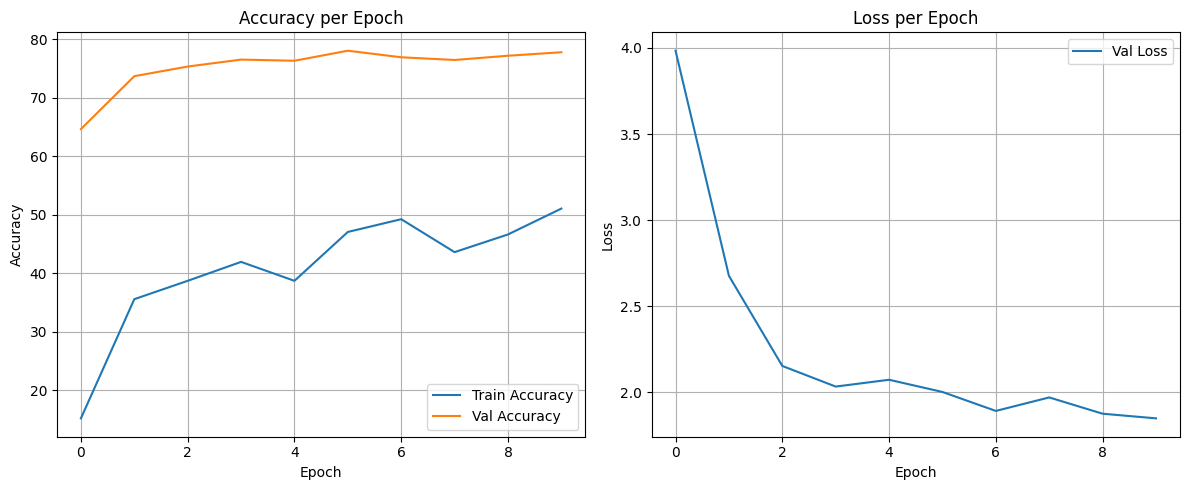

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
import os
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
from tqdm import tqdm

# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# Аугментации (теперь — только базовые, без аугментаций)
IMG_SIZE = 128
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
])

# Dataset
class CustomImageDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image, label

# Разделение
def get_stratified_datasets(root_dir, test_size=0.2):
    all_samples = []
    all_labels = []
    class_names = sorted(os.listdir(root_dir))
    for class_id in class_names:
        class_path = os.path.join(root_dir, class_id)
        if os.path.isdir(class_path):
            for fname in os.listdir(class_path):
                fpath = os.path.join(class_path, fname)
                all_samples.append((fpath, int(class_id)))
                all_labels.append(int(class_id))

    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    train_idx, val_idx = next(splitter.split(all_samples, all_labels))
    train_samples = [all_samples[i] for i in train_idx]
    val_samples = [all_samples[i] for i in val_idx]
    return train_samples, val_samples, class_names

train_samples, val_samples, class_names = get_stratified_datasets("data_split/train")

train_dataset = CustomImageDataset(train_samples, transform=train_transform)
val_dataset = CustomImageDataset(val_samples, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Class Weights
def get_class_weights(samples, num_classes):
    label_counts = Counter([label for _, label in samples])
    class_weights = [0] * num_classes
    total = sum(label_counts.values())
    for i in range(num_classes):
        class_weights[i] = total / (num_classes * label_counts[i])
    return torch.tensor(class_weights, dtype=torch.float)

class_weights = get_class_weights(train_samples, len(class_names)).to(device)

# Модель wide_resnet50_2
model = timm.create_model('wide_resnet50_2', pretrained=True, num_classes=len(class_names))
model = model.to(device)

# Размораживаем всё
for param in model.parameters():
    param.requires_grad = True

# Loss
criterion = nn.CrossEntropyLoss(label_smoothing=0.1, weight=class_weights)

# Mixup
def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Оптимизация и LR Scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

# Тренировка
best_val_acc = 0
early_stop_patience = 4
no_improve_epochs = 0
num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    epoch_loss = running_loss / total

    # Валидация + TTA
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            tta_outputs = []
            for tta in [lambda x: x, lambda x: torch.flip(x, dims=[3]), lambda x: torch.flip(x, dims=[2])]:
                tta_inputs = tta(inputs)
                tta_outputs.append(model(tta_inputs))
            outputs = sum(tta_outputs) / len(tta_outputs)

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    scheduler.step(val_acc)

    print(f"Эпоха {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
    print("LR:", optimizer.param_groups[0]['lr'])

    train_accuracies.append(train_acc)
    val_losses.append(epoch_loss)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model_wide_resnet50_2_no_aug.pth")
        print("Сохраняем модель")
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        print(f"Нет улучшения уже {no_improve_epochs} эпох")

    if no_improve_epochs >= early_stop_patience:
        print("Ранняя остановка")
        break

print(f"\n Лучшая validation accuracy: {best_val_acc:.2f}%")



# Графики loss и accuracy
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)

plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 3.3 Без Transfer learning

В этом блоке рассмотрена другая модель, написанная без применения TL, с разными аугментациями, с подробным выводом результатов, визуализацией и анализом исходов

### 3.3.1 с навороченными аугментациями

Использую аугментации как в 3.2 для другой модели

<ipython-input-10-f3ec8cd91ff8>:35: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
Epoch 1/40: 100%|██████████| 119/119 [00:20<00:00,  5.80it/s]


Эпоха 1, Train Acc: 5.22%, Val Acc: 7.33%, Val Loss: 4.0701
Сохраняем модель


Epoch 2/40: 100%|██████████| 119/119 [00:19<00:00,  6.00it/s]


Эпоха 2, Train Acc: 7.01%, Val Acc: 8.05%, Val Loss: 4.0207
Сохраняем модель


Epoch 3/40: 100%|██████████| 119/119 [00:19<00:00,  5.98it/s]


Эпоха 3, Train Acc: 8.20%, Val Acc: 8.72%, Val Loss: 3.9600
Сохраняем модель


Epoch 4/40: 100%|██████████| 119/119 [00:20<00:00,  5.91it/s]


Эпоха 4, Train Acc: 9.44%, Val Acc: 10.42%, Val Loss: 3.9056
Сохраняем модель


Epoch 5/40: 100%|██████████| 119/119 [00:20<00:00,  5.75it/s]


Эпоха 5, Train Acc: 9.83%, Val Acc: 12.23%, Val Loss: 3.7626
Сохраняем модель


Epoch 6/40: 100%|██████████| 119/119 [00:19<00:00,  6.00it/s]


Эпоха 6, Train Acc: 10.74%, Val Acc: 10.99%, Val Loss: 3.7843
Не было улучшений уже 1 эпох


Epoch 7/40: 100%|██████████| 119/119 [00:20<00:00,  5.87it/s]


Эпоха 7, Train Acc: 11.63%, Val Acc: 13.36%, Val Loss: 3.7373
Сохраняем модель


Epoch 8/40: 100%|██████████| 119/119 [00:20<00:00,  5.70it/s]


Эпоха 8, Train Acc: 13.03%, Val Acc: 13.83%, Val Loss: 3.6053
Сохраняем модель


Epoch 9/40: 100%|██████████| 119/119 [00:21<00:00,  5.64it/s]


Эпоха 9, Train Acc: 13.89%, Val Acc: 15.38%, Val Loss: 3.5762
Сохраняем модель


Epoch 10/40: 100%|██████████| 119/119 [00:20<00:00,  5.77it/s]


Эпоха 10, Train Acc: 14.67%, Val Acc: 18.01%, Val Loss: 3.4642
Сохраняем модель


Epoch 11/40: 100%|██████████| 119/119 [00:20<00:00,  5.77it/s]


Эпоха 11, Train Acc: 16.13%, Val Acc: 18.06%, Val Loss: 3.3530
Сохраняем модель


Epoch 12/40: 100%|██████████| 119/119 [00:21<00:00,  5.56it/s]


Эпоха 12, Train Acc: 17.51%, Val Acc: 19.87%, Val Loss: 3.3055
Сохраняем модель


Epoch 13/40: 100%|██████████| 119/119 [00:21<00:00,  5.42it/s]


Эпоха 13, Train Acc: 19.04%, Val Acc: 21.36%, Val Loss: 3.1974
Сохраняем модель


Epoch 14/40: 100%|██████████| 119/119 [00:21<00:00,  5.47it/s]


Эпоха 14, Train Acc: 19.96%, Val Acc: 22.50%, Val Loss: 3.1847
Сохраняем модель


Epoch 15/40: 100%|██████████| 119/119 [00:21<00:00,  5.53it/s]


Эпоха 15, Train Acc: 21.72%, Val Acc: 23.79%, Val Loss: 3.0586
Сохраняем модель


Epoch 16/40: 100%|██████████| 119/119 [00:20<00:00,  5.78it/s]


Эпоха 16, Train Acc: 23.52%, Val Acc: 22.96%, Val Loss: 3.1165
Не было улучшений уже 1 эпох


Epoch 17/40: 100%|██████████| 119/119 [00:20<00:00,  5.84it/s]


Эпоха 17, Train Acc: 25.96%, Val Acc: 26.26%, Val Loss: 3.0074
Сохраняем модель


Epoch 18/40: 100%|██████████| 119/119 [00:22<00:00,  5.33it/s]


Эпоха 18, Train Acc: 26.91%, Val Acc: 28.07%, Val Loss: 2.8337
Сохраняем модель


Epoch 19/40: 100%|██████████| 119/119 [00:21<00:00,  5.51it/s]


Эпоха 19, Train Acc: 28.90%, Val Acc: 28.84%, Val Loss: 2.8452
Сохраняем модель


Epoch 20/40: 100%|██████████| 119/119 [00:21<00:00,  5.50it/s]


Эпоха 20, Train Acc: 29.82%, Val Acc: 29.72%, Val Loss: 2.8455
Сохраняем модель


Epoch 21/40: 100%|██████████| 119/119 [00:19<00:00,  5.95it/s]


Эпоха 21, Train Acc: 31.46%, Val Acc: 31.53%, Val Loss: 2.6959
Сохраняем модель


Epoch 22/40: 100%|██████████| 119/119 [00:20<00:00,  5.73it/s]


Эпоха 22, Train Acc: 33.61%, Val Acc: 30.91%, Val Loss: 2.6893
Не было улучшений уже 1 эпох


Epoch 23/40: 100%|██████████| 119/119 [00:21<00:00,  5.54it/s]


Эпоха 23, Train Acc: 33.90%, Val Acc: 33.28%, Val Loss: 2.6423
Сохраняем модель


Epoch 24/40: 100%|██████████| 119/119 [00:21<00:00,  5.50it/s]


Эпоха 24, Train Acc: 35.05%, Val Acc: 33.54%, Val Loss: 2.5927
Сохраняем модель


Epoch 25/40: 100%|██████████| 119/119 [00:21<00:00,  5.54it/s]


Эпоха 25, Train Acc: 37.30%, Val Acc: 34.93%, Val Loss: 2.5566
Сохраняем модель


Epoch 26/40: 100%|██████████| 119/119 [00:21<00:00,  5.47it/s]


Эпоха 26, Train Acc: 38.42%, Val Acc: 37.15%, Val Loss: 2.4418
Сохраняем модель


Epoch 27/40: 100%|██████████| 119/119 [00:21<00:00,  5.61it/s]


Эпоха 27, Train Acc: 38.84%, Val Acc: 35.81%, Val Loss: 2.5537
Не было улучшений уже 1 эпох


Epoch 28/40: 100%|██████████| 119/119 [00:20<00:00,  5.76it/s]


Эпоха 28, Train Acc: 40.52%, Val Acc: 38.18%, Val Loss: 2.4338
Сохраняем модель


Epoch 29/40: 100%|██████████| 119/119 [00:21<00:00,  5.67it/s]


Эпоха 29, Train Acc: 40.94%, Val Acc: 38.80%, Val Loss: 2.3925
Сохраняем модель


Epoch 30/40: 100%|██████████| 119/119 [00:21<00:00,  5.60it/s]


Эпоха 30, Train Acc: 42.68%, Val Acc: 38.34%, Val Loss: 2.4303
Не было улучшений уже 1 эпох


Epoch 31/40: 100%|██████████| 119/119 [00:21<00:00,  5.58it/s]


Эпоха 31, Train Acc: 43.11%, Val Acc: 40.92%, Val Loss: 2.2943
Сохраняем модель


Epoch 32/40: 100%|██████████| 119/119 [00:20<00:00,  5.80it/s]


Эпоха 32, Train Acc: 44.72%, Val Acc: 38.80%, Val Loss: 2.3818
Не было улучшений уже 1 эпох


Epoch 33/40: 100%|██████████| 119/119 [00:21<00:00,  5.61it/s]


Эпоха 33, Train Acc: 46.06%, Val Acc: 39.01%, Val Loss: 2.4001
Не было улучшений уже 2 эпох


Epoch 34/40: 100%|██████████| 119/119 [00:21<00:00,  5.64it/s]


Эпоха 34, Train Acc: 45.71%, Val Acc: 41.02%, Val Loss: 2.3324
Сохраняем модель


Epoch 35/40: 100%|██████████| 119/119 [00:21<00:00,  5.61it/s]


Эпоха 35, Train Acc: 47.73%, Val Acc: 41.59%, Val Loss: 2.2551
Сохраняем модель


Epoch 36/40: 100%|██████████| 119/119 [00:21<00:00,  5.66it/s]


Эпоха 36, Train Acc: 48.84%, Val Acc: 42.57%, Val Loss: 2.2474
Сохраняем модель


Epoch 37/40: 100%|██████████| 119/119 [00:21<00:00,  5.51it/s]


Эпоха 37, Train Acc: 49.29%, Val Acc: 41.69%, Val Loss: 2.3229
Не было улучшений уже 1 эпох


Epoch 38/40: 100%|██████████| 119/119 [00:21<00:00,  5.62it/s]


Эпоха 38, Train Acc: 50.52%, Val Acc: 43.55%, Val Loss: 2.1864
Сохраняем модель


Epoch 39/40: 100%|██████████| 119/119 [00:21<00:00,  5.62it/s]


Эпоха 39, Train Acc: 51.37%, Val Acc: 42.11%, Val Loss: 2.2691
Не было улучшений уже 1 эпох


Epoch 40/40: 100%|██████████| 119/119 [00:20<00:00,  5.68it/s]


Эпоха 40, Train Acc: 51.40%, Val Acc: 42.72%, Val Loss: 2.1984
Не было улучшений уже 2 эпох


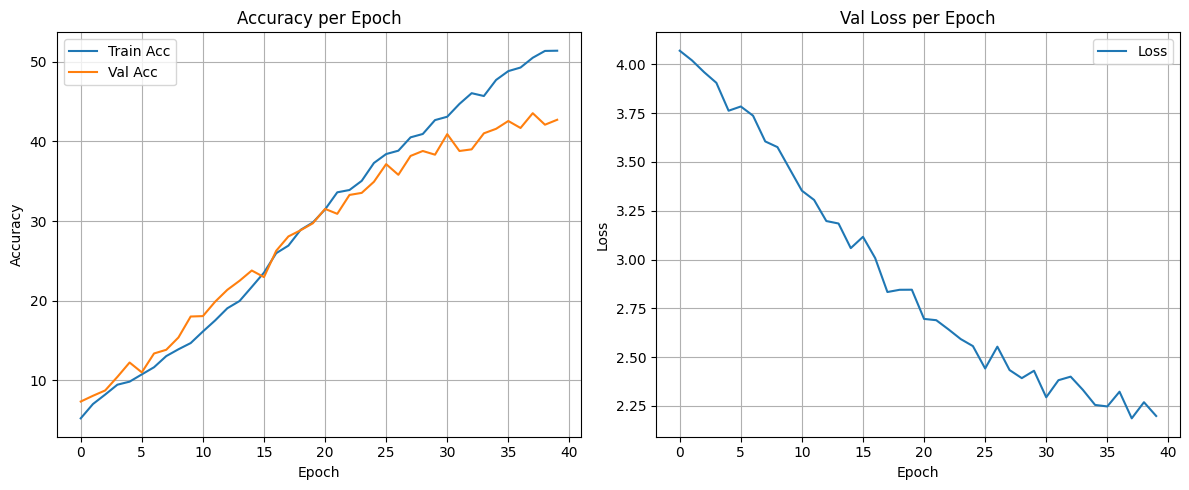

In [ ]:
import os
import random
import numpy as np
import shutil
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.datasets import ImageFolder

import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import matplotlib.pyplot as plt

# ========= 1. Настройки =========
IMG_SIZE = 128
BATCH_SIZE = 64
NUM_CLASSES = 100
NUM_EPOCHS = 40
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ========= 2. Аугментации =========
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.3),
    A.HueSaturationValue(p=0.2),
    A.RandomCrop(height=IMG_SIZE, width=IMG_SIZE, p=0.1),
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.2),
    A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.2),
    A.MotionBlur(p=0.2),
    A.ElasticTransform(p=0.1),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
])

# ========= 3. Обёртка под albumentations =========
class AlbumentationsDataset(ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root)
        self.albumentations_transform = transform

    def __getitem__(self, index):
        path, label = self.samples[index]
        image = Image.open(path).convert("RGB")
        image = np.array(image)

        if self.albumentations_transform:
            augmented = self.albumentations_transform(image=image)
            image = augmented['image']

        return image, label

# ========= 4. Датасеты и загрузчики =========
train_dataset = AlbumentationsDataset("data_split/train", transform=train_transform)
val_dataset = AlbumentationsDataset("data_split/val", transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ========= 5. Модель =========
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return self.relu(out)

class SimpleResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(32, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2)
        self.layer3 = self._make_layer(128, 256, 2)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_c, out_c, stride):
        return nn.Sequential(
            ResidualBlock(in_c, out_c, stride),
            ResidualBlock(out_c, out_c)
        )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.pool(out)
        out = torch.flatten(out, 1)
        return self.fc(out)

# ========= 6. Обучение =========
model = SimpleResNet(num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

best_val_acc = 0
no_improve_epochs = 0
early_stop_patience = 4

train_accuracies, val_accuracies = [], []
val_losses = []

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    running_loss, correct, total = 0, 0, 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    train_accuracies.append(train_acc)

    # Валидация
    model.eval()
    val_loss_total, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_total += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100. * val_correct / val_total
    val_accuracies.append(val_acc)
    val_loss = val_loss_total / len(val_loader)
    val_losses.append(val_loss)
    scheduler.step(val_acc)

    print(f"Эпоха {epoch}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Val Loss: {val_loss:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve_epochs = 0
        torch.save(model.state_dict(), "model_no_tl.pth")
        print("Сохраняем модель")
    else:
        no_improve_epochs += 1
        print(f"Не было улучшений уже {no_improve_epochs} эпох")
        if no_improve_epochs >= early_stop_patience:
            print("Ранняя остановка")
            break

# ========= 7. Графики =========
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Val Loss per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Эта модель не достигает таких высоких результатов, как wide_resnet, которую я ипользовала в качестве предобученной модели. При этом модель за 40 эпох не достигла "потолка", accuracy (как train, так и val) продолжает стабильно расти.

Несмотря на это, я думаю, что увеличение количества эпох не приведет к хорошему результату, потому что уже на данном этапе начинается переобучение. Об этом говорит то, что train acc начинает расти быстрее val acc. Если побороть переобучение, модель может достичь более высоких результатов, но она все равно обучается медленнее предобученной

### 3.3.2 без навороченных аугментаций (только отражения)

Также модель без изменений, чтобы корректно оценить влияние аугментаций

Epoch 1/40: 100%|██████████| 119/119 [00:20<00:00,  5.80it/s]


Эпоха 1/40, Loss: 4.2061, Train Acc: 6.85%, Val Acc: 8.77%
LR: 0.001
Сохраняем модель


Epoch 2/40: 100%|██████████| 119/119 [00:20<00:00,  5.84it/s]


Эпоха 2/40, Loss: 3.9874, Train Acc: 8.98%, Val Acc: 9.34%
LR: 0.001
Сохраняем модель


Epoch 3/40: 100%|██████████| 119/119 [00:20<00:00,  5.87it/s]


Эпоха 3/40, Loss: 3.9058, Train Acc: 10.09%, Val Acc: 9.29%
LR: 0.001
Нет улучшения уже 1 эпох


Epoch 4/40: 100%|██████████| 119/119 [00:20<00:00,  5.93it/s]


Эпоха 4/40, Loss: 3.8574, Train Acc: 10.90%, Val Acc: 11.15%
LR: 0.001
Сохраняем модель


Epoch 5/40: 100%|██████████| 119/119 [00:19<00:00,  5.96it/s]


Эпоха 5/40, Loss: 3.7994, Train Acc: 11.25%, Val Acc: 11.61%
LR: 0.001
Сохраняем модель


Epoch 6/40: 100%|██████████| 119/119 [00:20<00:00,  5.85it/s]


Эпоха 6/40, Loss: 3.7310, Train Acc: 12.82%, Val Acc: 11.61%
LR: 0.001
Нет улучшения уже 1 эпох


Epoch 7/40: 100%|██████████| 119/119 [00:20<00:00,  5.92it/s]


Эпоха 7/40, Loss: 3.6566, Train Acc: 14.08%, Val Acc: 13.83%
LR: 0.001
Сохраняем модель


Epoch 8/40: 100%|██████████| 119/119 [00:20<00:00,  5.90it/s]


Эпоха 8/40, Loss: 3.6145, Train Acc: 14.50%, Val Acc: 13.36%
LR: 0.001
Нет улучшения уже 1 эпох


Epoch 9/40: 100%|██████████| 119/119 [00:20<00:00,  5.94it/s]


Эпоха 9/40, Loss: 3.5457, Train Acc: 15.54%, Val Acc: 14.71%
LR: 0.001
Сохраняем модель


Epoch 10/40: 100%|██████████| 119/119 [00:20<00:00,  5.92it/s]


Эпоха 10/40, Loss: 3.4940, Train Acc: 16.55%, Val Acc: 12.59%
LR: 0.001
Нет улучшения уже 1 эпох


Epoch 11/40: 100%|██████████| 119/119 [00:20<00:00,  5.92it/s]


Эпоха 11/40, Loss: 3.4068, Train Acc: 17.91%, Val Acc: 17.39%
LR: 0.001
Сохраняем модель


Epoch 12/40: 100%|██████████| 119/119 [00:19<00:00,  5.96it/s]


Эпоха 12/40, Loss: 3.3352, Train Acc: 18.71%, Val Acc: 18.01%
LR: 0.001
Сохраняем модель


Epoch 13/40: 100%|██████████| 119/119 [00:20<00:00,  5.82it/s]


Эпоха 13/40, Loss: 3.2475, Train Acc: 20.43%, Val Acc: 18.58%
LR: 0.001
Сохраняем модель


Epoch 14/40: 100%|██████████| 119/119 [00:20<00:00,  5.92it/s]


Эпоха 14/40, Loss: 3.1384, Train Acc: 22.75%, Val Acc: 21.52%
LR: 0.001
Сохраняем модель


Epoch 15/40: 100%|██████████| 119/119 [00:20<00:00,  5.92it/s]


Эпоха 15/40, Loss: 3.0571, Train Acc: 24.37%, Val Acc: 21.36%
LR: 0.001
Нет улучшения уже 1 эпох


Epoch 16/40: 100%|██████████| 119/119 [00:19<00:00,  5.96it/s]


Эпоха 16/40, Loss: 2.9589, Train Acc: 25.81%, Val Acc: 22.29%
LR: 0.001
Сохраняем модель


Epoch 17/40: 100%|██████████| 119/119 [00:20<00:00,  5.91it/s]


Эпоха 17/40, Loss: 2.8804, Train Acc: 27.30%, Val Acc: 24.56%
LR: 0.001
Сохраняем модель


Epoch 18/40: 100%|██████████| 119/119 [00:20<00:00,  5.91it/s]


Эпоха 18/40, Loss: 2.7766, Train Acc: 28.42%, Val Acc: 24.36%
LR: 0.001
Нет улучшения уже 1 эпох


Epoch 19/40: 100%|██████████| 119/119 [00:20<00:00,  5.92it/s]


Эпоха 19/40, Loss: 2.6824, Train Acc: 31.11%, Val Acc: 26.11%
LR: 0.001
Сохраняем модель


Epoch 20/40: 100%|██████████| 119/119 [00:19<00:00,  5.95it/s]


Эпоха 20/40, Loss: 2.6121, Train Acc: 32.54%, Val Acc: 26.26%
LR: 0.001
Сохраняем модель


Epoch 21/40: 100%|██████████| 119/119 [00:20<00:00,  5.90it/s]


Эпоха 21/40, Loss: 2.5341, Train Acc: 33.58%, Val Acc: 28.28%
LR: 0.001
Сохраняем модель


Epoch 22/40: 100%|██████████| 119/119 [00:20<00:00,  5.91it/s]


Эпоха 22/40, Loss: 2.4425, Train Acc: 35.90%, Val Acc: 28.28%
LR: 0.001
Нет улучшения уже 1 эпох


Epoch 23/40: 100%|██████████| 119/119 [00:20<00:00,  5.91it/s]


Эпоха 23/40, Loss: 2.3549, Train Acc: 37.59%, Val Acc: 30.34%
LR: 0.001
Сохраняем модель


Epoch 24/40: 100%|██████████| 119/119 [00:20<00:00,  5.93it/s]


Эпоха 24/40, Loss: 2.3085, Train Acc: 38.51%, Val Acc: 30.44%
LR: 0.001
Сохраняем модель


Epoch 25/40: 100%|██████████| 119/119 [00:20<00:00,  5.94it/s]


Эпоха 25/40, Loss: 2.2207, Train Acc: 40.64%, Val Acc: 30.55%
LR: 0.001
Сохраняем модель


Epoch 26/40: 100%|██████████| 119/119 [00:20<00:00,  5.90it/s]


Эпоха 26/40, Loss: 2.1609, Train Acc: 42.63%, Val Acc: 32.82%
LR: 0.001
Сохраняем модель


Epoch 27/40: 100%|██████████| 119/119 [00:20<00:00,  5.91it/s]


Эпоха 27/40, Loss: 2.1004, Train Acc: 43.45%, Val Acc: 33.64%
LR: 0.001
Сохраняем модель


Epoch 28/40: 100%|██████████| 119/119 [00:20<00:00,  5.95it/s]


Эпоха 28/40, Loss: 2.0291, Train Acc: 44.98%, Val Acc: 34.37%
LR: 0.001
Сохраняем модель


Epoch 29/40: 100%|██████████| 119/119 [00:19<00:00,  5.95it/s]


Эпоха 29/40, Loss: 1.9575, Train Acc: 46.61%, Val Acc: 32.30%
LR: 0.001
Нет улучшения уже 1 эпох


Epoch 30/40: 100%|██████████| 119/119 [00:20<00:00,  5.92it/s]


Эпоха 30/40, Loss: 1.8909, Train Acc: 48.14%, Val Acc: 35.09%
LR: 0.001
Сохраняем модель


Epoch 31/40: 100%|██████████| 119/119 [00:20<00:00,  5.92it/s]


Эпоха 31/40, Loss: 1.8420, Train Acc: 49.12%, Val Acc: 34.78%
LR: 0.001
Нет улучшения уже 1 эпох


Epoch 32/40: 100%|██████████| 119/119 [00:20<00:00,  5.95it/s]


Эпоха 32/40, Loss: 1.7975, Train Acc: 50.85%, Val Acc: 35.55%
LR: 0.001
Сохраняем модель


Epoch 33/40: 100%|██████████| 119/119 [00:20<00:00,  5.94it/s]


Эпоха 33/40, Loss: 1.7300, Train Acc: 52.72%, Val Acc: 36.07%
LR: 0.001
Сохраняем модель


Epoch 34/40: 100%|██████████| 119/119 [00:20<00:00,  5.89it/s]


Эпоха 34/40, Loss: 1.6721, Train Acc: 53.41%, Val Acc: 36.07%
LR: 0.001
Нет улучшения уже 1 эпох


Epoch 35/40: 100%|██████████| 119/119 [00:20<00:00,  5.91it/s]


Эпоха 35/40, Loss: 1.6117, Train Acc: 55.34%, Val Acc: 36.33%
LR: 0.001
Сохраняем модель


Epoch 36/40: 100%|██████████| 119/119 [00:20<00:00,  5.95it/s]


Эпоха 36/40, Loss: 1.5749, Train Acc: 55.81%, Val Acc: 37.20%
LR: 0.001
Сохраняем модель


Epoch 37/40: 100%|██████████| 119/119 [00:20<00:00,  5.93it/s]


Эпоха 37/40, Loss: 1.4976, Train Acc: 57.98%, Val Acc: 36.58%
LR: 0.001
Нет улучшения уже 1 эпох


Epoch 38/40: 100%|██████████| 119/119 [00:20<00:00,  5.88it/s]


Эпоха 38/40, Loss: 1.4473, Train Acc: 58.99%, Val Acc: 37.31%
LR: 0.001
Сохраняем модель


Epoch 39/40: 100%|██████████| 119/119 [00:20<00:00,  5.90it/s]


Эпоха 39/40, Loss: 1.3982, Train Acc: 59.94%, Val Acc: 36.33%
LR: 0.001
Нет улучшения уже 1 эпох


Epoch 40/40: 100%|██████████| 119/119 [00:20<00:00,  5.94it/s]


Эпоха 40/40, Loss: 1.3438, Train Acc: 61.45%, Val Acc: 36.79%
LR: 0.001
Нет улучшения уже 2 эпох


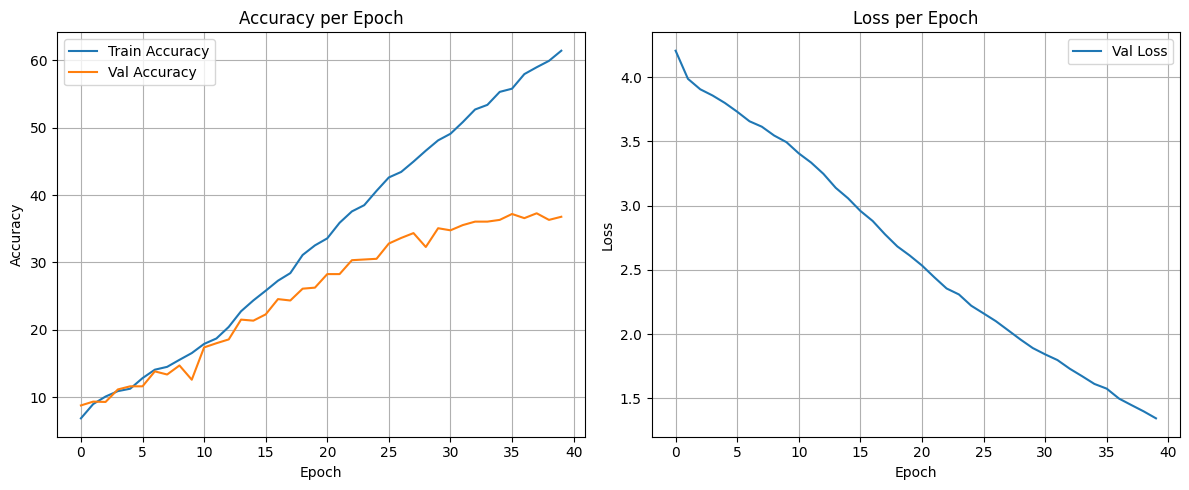

In [ ]:
import os
import random
import numpy as np
import shutil
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []


# ====== 2. Аугментации ======
image_size = 128

train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ====== 3. Датасеты и лоадеры ======
train_dataset = datasets.ImageFolder("data_split/train", transform=train_transforms)
val_dataset = datasets.ImageFolder("data_split/val", transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

# ====== 4. Модель ======
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class SimpleResNet(nn.Module):
    def __init__(self, num_classes=100):
        super(SimpleResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(32, 64, stride=2)
        self.layer2 = self._make_layer(64, 128, stride=2)
        self.layer3 = self._make_layer(128, 256, stride=2)

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, stride):
        layers = [
            ResidualBlock(in_channels, out_channels, stride),
            ResidualBlock(out_channels, out_channels, stride=1)
        ]
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        out = self.global_avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

# ====== 5. Обучение ======
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleResNet(num_classes=100).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

best_val_acc = 0
no_improve_epochs = 0
early_stop_patience = 5  # сколько эпох без улучшения ждать

num_epochs = 40

for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total

    # Валидация
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100. * val_correct / val_total
    scheduler.step(val_acc)

    print(f"Эпоха {epoch}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
    print(f"LR: {optimizer.param_groups[0]['lr']}")

    train_accuracies.append(train_acc)
    val_losses.append(train_loss)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve_epochs = 0  # обнулили счётчик
        torch.save(model.state_dict(), "model_no_tl_aug.pth")
        print("Сохраняем модель")
    else:
        no_improve_epochs += 1
        print(f"Нет улучшения уже {no_improve_epochs} эпох")

        if no_improve_epochs >= early_stop_patience:
            print("Ранняя остановка")
            break

# Графики loss и accuracy
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)

plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Аналогично варианту со сложными аугментациями и train acc, и val acc продолжают расти спустя 40 эпох

При этом переобучение гораздо более выраженное, и по val acc похоже, что модель начинает достигать "потолок"

Вывод - для такой модели сложные аугментации необходимы

### без аугментаций

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/40: 100%|██████████| 119/119 [00:20<00:00,  5.75it/s]


Эпоха 1/40, Loss: 4.2070, Train Acc: 6.71%, Val Acc: 9.34%
LR: 0.001
Сохраняем модель


Epoch 2/40: 100%|██████████| 119/119 [00:20<00:00,  5.89it/s]


Эпоха 2/40, Loss: 3.9768, Train Acc: 9.19%, Val Acc: 9.80%
LR: 0.001
Сохраняем модель


Epoch 3/40: 100%|██████████| 119/119 [00:19<00:00,  5.95it/s]


Эпоха 3/40, Loss: 3.8623, Train Acc: 10.29%, Val Acc: 11.35%
LR: 0.001
Сохраняем модель


Epoch 4/40: 100%|██████████| 119/119 [00:20<00:00,  5.95it/s]


Эпоха 4/40, Loss: 3.7893, Train Acc: 11.69%, Val Acc: 11.15%
LR: 0.001
Нет улучшения уже 1 эпох


Epoch 5/40: 100%|██████████| 119/119 [00:20<00:00,  5.94it/s]


Эпоха 5/40, Loss: 3.7178, Train Acc: 12.89%, Val Acc: 13.00%
LR: 0.001
Сохраняем модель


Epoch 6/40: 100%|██████████| 119/119 [00:20<00:00,  5.94it/s]


Эпоха 6/40, Loss: 3.6543, Train Acc: 13.88%, Val Acc: 12.85%
LR: 0.001
Нет улучшения уже 1 эпох


Epoch 7/40: 100%|██████████| 119/119 [00:19<00:00,  5.96it/s]


Эпоха 7/40, Loss: 3.5870, Train Acc: 14.40%, Val Acc: 13.73%
LR: 0.001
Сохраняем модель


Epoch 8/40: 100%|██████████| 119/119 [00:20<00:00,  5.78it/s]


Эпоха 8/40, Loss: 3.5001, Train Acc: 15.54%, Val Acc: 15.22%
LR: 0.001
Сохраняем модель


Epoch 9/40: 100%|██████████| 119/119 [00:20<00:00,  5.95it/s]


Эпоха 9/40, Loss: 3.4312, Train Acc: 17.22%, Val Acc: 15.89%
LR: 0.001
Сохраняем модель


Epoch 10/40: 100%|██████████| 119/119 [00:20<00:00,  5.94it/s]


Эпоха 10/40, Loss: 3.3540, Train Acc: 18.73%, Val Acc: 16.77%
LR: 0.001
Сохраняем модель


Epoch 11/40: 100%|██████████| 119/119 [00:19<00:00,  5.96it/s]


Эпоха 11/40, Loss: 3.2642, Train Acc: 20.29%, Val Acc: 17.49%
LR: 0.001
Сохраняем модель


Epoch 12/40: 100%|██████████| 119/119 [00:20<00:00,  5.88it/s]


Эпоха 12/40, Loss: 3.1443, Train Acc: 22.39%, Val Acc: 20.59%
LR: 0.001
Сохраняем модель


Epoch 13/40: 100%|██████████| 119/119 [00:20<00:00,  5.87it/s]


Эпоха 13/40, Loss: 3.0610, Train Acc: 23.93%, Val Acc: 22.50%
LR: 0.001
Сохраняем модель


Epoch 14/40: 100%|██████████| 119/119 [00:20<00:00,  5.92it/s]


Эпоха 14/40, Loss: 2.9540, Train Acc: 25.86%, Val Acc: 20.43%
LR: 0.001
Нет улучшения уже 1 эпох


Epoch 15/40: 100%|██████████| 119/119 [00:19<00:00,  5.96it/s]


Эпоха 15/40, Loss: 2.8682, Train Acc: 27.79%, Val Acc: 25.18%
LR: 0.001
Сохраняем модель


Epoch 16/40: 100%|██████████| 119/119 [00:20<00:00,  5.90it/s]


Эпоха 16/40, Loss: 2.7727, Train Acc: 28.96%, Val Acc: 25.03%
LR: 0.001
Нет улучшения уже 1 эпох


Epoch 17/40: 100%|██████████| 119/119 [00:20<00:00,  5.91it/s]


Эпоха 17/40, Loss: 2.6885, Train Acc: 31.27%, Val Acc: 26.47%
LR: 0.001
Сохраняем модель


Epoch 18/40: 100%|██████████| 119/119 [00:20<00:00,  5.94it/s]


Эпоха 18/40, Loss: 2.5925, Train Acc: 32.95%, Val Acc: 28.43%
LR: 0.001
Сохраняем модель


Epoch 19/40: 100%|██████████| 119/119 [00:19<00:00,  5.95it/s]


Эпоха 19/40, Loss: 2.5317, Train Acc: 34.05%, Val Acc: 26.47%
LR: 0.001
Нет улучшения уже 1 эпох


Epoch 20/40: 100%|██████████| 119/119 [00:20<00:00,  5.89it/s]


Эпоха 20/40, Loss: 2.4393, Train Acc: 36.12%, Val Acc: 30.24%
LR: 0.001
Сохраняем модель


Epoch 21/40: 100%|██████████| 119/119 [00:20<00:00,  5.88it/s]


Эпоха 21/40, Loss: 2.3576, Train Acc: 37.72%, Val Acc: 31.79%
LR: 0.001
Сохраняем модель


Epoch 22/40: 100%|██████████| 119/119 [00:20<00:00,  5.92it/s]


Эпоха 22/40, Loss: 2.2740, Train Acc: 40.20%, Val Acc: 32.15%
LR: 0.001
Сохраняем модель


Epoch 23/40: 100%|██████████| 119/119 [00:20<00:00,  5.91it/s]


Эпоха 23/40, Loss: 2.2151, Train Acc: 40.95%, Val Acc: 32.51%
LR: 0.001
Сохраняем модель


Epoch 24/40: 100%|██████████| 119/119 [00:20<00:00,  5.89it/s]


Эпоха 24/40, Loss: 2.1598, Train Acc: 42.12%, Val Acc: 33.49%
LR: 0.001
Сохраняем модель


Epoch 25/40: 100%|██████████| 119/119 [00:20<00:00,  5.90it/s]


Эпоха 25/40, Loss: 2.0721, Train Acc: 44.28%, Val Acc: 33.64%
LR: 0.001
Сохраняем модель


Epoch 26/40: 100%|██████████| 119/119 [00:20<00:00,  5.92it/s]


Эпоха 26/40, Loss: 2.0078, Train Acc: 45.02%, Val Acc: 34.62%
LR: 0.001
Сохраняем модель


Epoch 27/40: 100%|██████████| 119/119 [00:20<00:00,  5.93it/s]


Эпоха 27/40, Loss: 1.9738, Train Acc: 46.12%, Val Acc: 34.47%
LR: 0.001
Нет улучшения уже 1 эпох


Epoch 28/40: 100%|██████████| 119/119 [00:20<00:00,  5.91it/s]


Эпоха 28/40, Loss: 1.8962, Train Acc: 48.07%, Val Acc: 35.14%
LR: 0.001
Сохраняем модель


Epoch 29/40: 100%|██████████| 119/119 [00:20<00:00,  5.89it/s]


Эпоха 29/40, Loss: 1.8273, Train Acc: 49.34%, Val Acc: 34.47%
LR: 0.001
Нет улучшения уже 1 эпох


Epoch 30/40: 100%|██████████| 119/119 [00:20<00:00,  5.88it/s]


Эпоха 30/40, Loss: 1.7784, Train Acc: 50.57%, Val Acc: 37.41%
LR: 0.001
Сохраняем модель


Epoch 31/40: 100%|██████████| 119/119 [00:20<00:00,  5.91it/s]


Эпоха 31/40, Loss: 1.7057, Train Acc: 52.67%, Val Acc: 33.90%
LR: 0.001
Нет улучшения уже 1 эпох


Epoch 32/40: 100%|██████████| 119/119 [00:20<00:00,  5.90it/s]


Эпоха 32/40, Loss: 1.6501, Train Acc: 54.13%, Val Acc: 35.24%
LR: 0.001
Нет улучшения уже 2 эпох


Epoch 33/40: 100%|██████████| 119/119 [00:20<00:00,  5.91it/s]


Эпоха 33/40, Loss: 1.6071, Train Acc: 54.70%, Val Acc: 35.91%
LR: 0.001
Нет улучшения уже 3 эпох


Epoch 34/40: 100%|██████████| 119/119 [00:20<00:00,  5.91it/s]


Эпоха 34/40, Loss: 1.5383, Train Acc: 56.70%, Val Acc: 38.96%
LR: 0.001
Сохраняем модель


Epoch 35/40: 100%|██████████| 119/119 [00:20<00:00,  5.94it/s]


Эпоха 35/40, Loss: 1.4947, Train Acc: 57.55%, Val Acc: 36.79%
LR: 0.001
Нет улучшения уже 1 эпох


Epoch 36/40: 100%|██████████| 119/119 [00:20<00:00,  5.88it/s]


Эпоха 36/40, Loss: 1.4354, Train Acc: 59.31%, Val Acc: 38.70%
LR: 0.001
Нет улучшения уже 2 эпох


Epoch 37/40: 100%|██████████| 119/119 [00:20<00:00,  5.89it/s]


Эпоха 37/40, Loss: 1.3902, Train Acc: 60.94%, Val Acc: 37.67%
LR: 0.001
Нет улучшения уже 3 эпох


Epoch 38/40: 100%|██████████| 119/119 [00:20<00:00,  5.91it/s]


Эпоха 38/40, Loss: 1.3540, Train Acc: 60.83%, Val Acc: 37.77%
LR: 0.001
Нет улучшения уже 4 эпох


Epoch 39/40: 100%|██████████| 119/119 [00:19<00:00,  5.95it/s]


Эпоха 39/40, Loss: 1.2833, Train Acc: 63.10%, Val Acc: 38.13%
LR: 0.001
Нет улучшения уже 5 эпох
Ранняя остановка


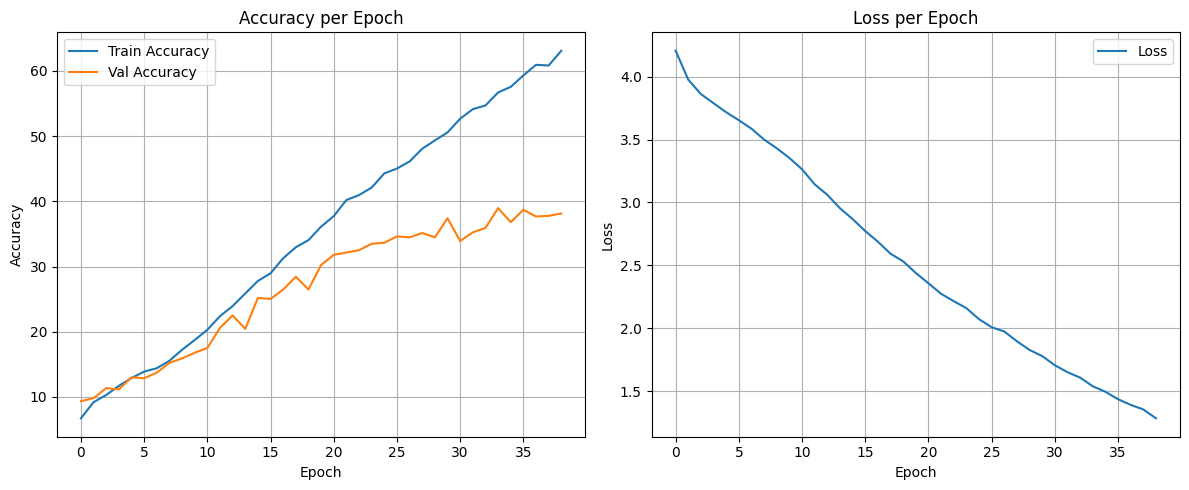

In [ ]:
import os
import random
import numpy as np
import shutil
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# Аугментации (теперь — только базовые, без аугментаций)
IMG_SIZE = 128
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
])

# ====== 3. Датасеты и лоадеры ======
train_dataset = datasets.ImageFolder("data_split/train", transform=train_transforms)
val_dataset = datasets.ImageFolder("data_split/val", transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

# ====== 4. Модель ======
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class SimpleResNet(nn.Module):
    def __init__(self, num_classes=100):
        super(SimpleResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(32, 64, stride=2)
        self.layer2 = self._make_layer(64, 128, stride=2)
        self.layer3 = self._make_layer(128, 256, stride=2)

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, stride):
        layers = [
            ResidualBlock(in_channels, out_channels, stride),
            ResidualBlock(out_channels, out_channels, stride=1)
        ]
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        out = self.global_avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

# ====== 5. Обучение ======
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleResNet(num_classes=100).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

best_val_acc = 0

num_epochs = 40

for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total

    # Валидация
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100. * val_correct / val_total
    scheduler.step(val_acc)

    print(f"Эпоха {epoch}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
    print(f"LR: {optimizer.param_groups[0]['lr']}")

    train_accuracies.append(train_acc)
    val_losses.append(train_loss)
    val_accuracies.append(val_acc)


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve_epochs = 0  # обнулили счётчик
        torch.save(model.state_dict(), "best_model_no_tl_no_aug.pth")
        print("Сохраняем модель")
    else:
        no_improve_epochs += 1
        print(f"Нет улучшения уже {no_improve_epochs} эпох")

        if no_improve_epochs >= early_stop_patience:
            print("Ранняя остановка")
            break


# Графики loss и accuracy
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)

plt.plot(val_losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Результаты очень похожи на те, что были у модели с простыми аугментациями, но тут обучение еще и проходит гораздо более неравномерно.

Также этот вариант модели показал самые низкие значения val accuracy из всех трех

Для моей не предобученной модели очень важны сложные хорошие аугментации, без них она прям плохо показывает себя

# Блок 4. Обучение генератора

В этом блоке будет обучение генератора и анализ результатов обучения модели со сгенерированными картинками

## Генератор (GAN)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

IMG_SIZE = 128
NUM_CLASSES = 100
Z_DIM = 100

In [ ]:
import os
from sklearn.model_selection import StratifiedShuffleSplit

def get_stratified_datasets(root_dir, test_size=0.2):
    all_samples = []
    all_labels = []
    class_names = sorted(os.listdir(root_dir))
    for class_id in class_names:
        class_path = os.path.join(root_dir, class_id)
        if os.path.isdir(class_path):
            for fname in os.listdir(class_path):
                fpath = os.path.join(class_path, fname)
                all_samples.append((fpath, int(class_id)))
                all_labels.append(int(class_id))

    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    train_idx, val_idx = next(splitter.split(all_samples, all_labels))
    train_samples = [all_samples[i] for i in train_idx]
    val_samples = [all_samples[i] for i in val_idx]
    return train_samples, val_samples, class_names


In [ ]:
train_samples, val_samples, class_names = get_stratified_datasets("data_split/train")


In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim, num_classes, img_size):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(z_dim + num_classes, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((noise, self.label_emb(labels)), -1)
        out = self.l1(gen_input)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, num_classes, img_size):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.model = nn.Sequential(
            nn.Conv2d(3 + 1, 64, 3, stride=2, padding=1),  # 3 channels + 1 for label
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ZeroPad2d((0,1,0,1)),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(256, 512, 3, stride=2, padding=1),
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
        )

        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(512 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img, labels):
        # Expand label embeddings to match image size
        label_embeddings = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        label_embeddings = label_embeddings.expand(-1, -1, img.size(2), img.size(3))
        d_in = torch.cat((img, label_embeddings), 1)
        out = self.model(d_in)
        out = out.view(out.size(0), -1)
        validity = self.adv_layer(out)
        return validity


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm import tqdm
import numpy as np
import random

# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Размеры
IMG_SIZE = 128
NUM_CLASSES = 100
Z_DIM = 100
BATCH_SIZE = 64
GAN_EPOCHS = 20

# ---- Dataset (используем уже определённый ранее класс) ----
class CustomImageDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image, label

# ---- Простой трансформ для GAN ----
gan_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
])

# ---- Загружаем train_samples (из твоего кода) ----
# Если нужно, повтори или загрузи снова:
# train_samples, val_samples, class_names = get_stratified_datasets("data_split/train")

gan_dataset = CustomImageDataset(train_samples, transform=gan_transform)
train_loader = DataLoader(gan_dataset, batch_size=BATCH_SIZE, shuffle=True)

# ---- Генератор ----
class Generator(nn.Module):
    def __init__(self, z_dim, num_classes, img_size):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(z_dim + num_classes, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((noise, self.label_emb(labels)), -1)
        out = self.l1(gen_input)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# ---- Дискриминатор ----
class Discriminator(nn.Module):
    def __init__(self, num_classes, img_size):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, 1)
        self.img_size = img_size

        self.model = nn.Sequential(
            nn.Conv2d(4, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(256, 512, 3, stride=2, padding=1),
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
        )

        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(512 * ds_size * ds_size, 1), nn.Sigmoid())

    def forward(self, img, labels):
        label_map = self.label_emb(labels).view(-1, 1, 1, 1).expand(-1, 1, self.img_size, self.img_size)
        d_in = torch.cat((img, label_map), 1)
        out = self.model(d_in)
        out = out.view(out.size(0), -1)
        validity = self.adv_layer(out)
        return validity

# ---- Инициализация ----
generator = Generator(Z_DIM, NUM_CLASSES, IMG_SIZE).to(device)
discriminator = Discriminator(NUM_CLASSES, IMG_SIZE).to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

adversarial_loss = nn.BCELoss()

# ---- Обучение GAN ----
for epoch in range(GAN_EPOCHS):
    generator.train()
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        batch_size = imgs.size(0)

        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        # ====== Генератор ======
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, Z_DIM, device=device)
        gen_labels = torch.randint(0, NUM_CLASSES, (batch_size,), device=device)
        gen_imgs = generator(z, gen_labels)
        g_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), valid)
        g_loss.backward()
        optimizer_G.step()

        # ====== Дискриминатор ======
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(imgs, labels), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_labels), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Прогресс
        if i % 100 == 0:
            print(f"[Epoch {epoch+1}/{GAN_EPOCHS}] [Batch {i}/{len(train_loader)}] D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f}")

# ---- Генерация изображений по классам ----
os.makedirs("generated_images", exist_ok=True)
generator.eval()

for class_label in range(NUM_CLASSES):
    z = torch.randn(10, Z_DIM, device=device)
    labels = torch.full((10,), class_label, dtype=torch.long, device=device)
    with torch.no_grad():
        gen_imgs = generator(z, labels)
    for i, img in enumerate(gen_imgs):
        save_image(img, f"generated_images/class_{class_label}_{i}.png", normalize=True)


[Epoch 1/20] [Batch 0/95] D_loss: 0.6931 G_loss: 0.6946
[Epoch 2/20] [Batch 0/95] D_loss: 0.2108 G_loss: 2.2288
[Epoch 3/20] [Batch 0/95] D_loss: 0.2799 G_loss: 7.8329
[Epoch 4/20] [Batch 0/95] D_loss: 0.0782 G_loss: 3.9785
[Epoch 5/20] [Batch 0/95] D_loss: 3.5198 G_loss: 0.0284
[Epoch 6/20] [Batch 0/95] D_loss: 0.0100 G_loss: 4.1446
[Epoch 7/20] [Batch 0/95] D_loss: 0.0259 G_loss: 4.0138
[Epoch 8/20] [Batch 0/95] D_loss: 0.0083 G_loss: 6.4488
[Epoch 9/20] [Batch 0/95] D_loss: 0.0020 G_loss: 6.3085
[Epoch 10/20] [Batch 0/95] D_loss: 0.0053 G_loss: 6.4960
[Epoch 11/20] [Batch 0/95] D_loss: 0.0007 G_loss: 8.4066
[Epoch 12/20] [Batch 0/95] D_loss: 0.0069 G_loss: 7.1347
[Epoch 13/20] [Batch 0/95] D_loss: 0.0004 G_loss: 8.9197
[Epoch 14/20] [Batch 0/95] D_loss: 0.0002 G_loss: 9.0087
[Epoch 15/20] [Batch 0/95] D_loss: 0.0016 G_loss: 8.5632
[Epoch 16/20] [Batch 0/95] D_loss: 0.0004 G_loss: 6.8730
[Epoch 17/20] [Batch 0/95] D_loss: 0.0004 G_loss: 9.3732
[Epoch 18/20] [Batch 0/95] D_loss: 0.000

In [ ]:
LATENT_DIM = 100  # Размер вектора шума для генератора
class GANAugmentedDataset(Dataset):
    def __init__(self, real_samples, generator, transform, p_fake=0.3, latent_dim=100, num_classes=100):
        self.real_samples = real_samples
        self.generator = generator
        self.transform = transform
        self.p_fake = p_fake
        self.latent_dim = latent_dim
        self.num_classes = num_classes

    def __len__(self):
        return len(self.real_samples)

    def __getitem__(self, idx):
        if random.random() < self.p_fake:
            # Генерируем фейковое изображение
            label = random.randint(0, self.num_classes - 1)
            z = torch.randn(1, self.latent_dim).to(device)
            label_tensor = torch.tensor([label], dtype=torch.long).to(device)
            with torch.no_grad():
                gen_img = self.generator(z, label_tensor).squeeze(0).cpu()
            return gen_img, label
        else:
            # Загружаем реальное изображение
            img_path, label = self.real_samples[idx]
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if self.transform:
                image = self.transform(image=image)['image']
            return image, label


In [ ]:
augmented_dataset = GANAugmentedDataset(train_samples, generator, train_transform, p_fake=0.3, latent_dim=LATENT_DIM, num_classes=len(class_names))
augmented_loader = DataLoader(augmented_dataset, batch_size=32, shuffle=True)


теперь попробуем обучить выбранную лучшую модель со сгенерированными изображениями (p_fake=0.3 => их 30%)

<ipython-input-24-7cfa183988b9>:31: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/40: 100%|██████████| 190/190 [01:03<00:00,  3.01it/s]


Эпоха 1/40, Loss: 4.2023, Train Acc: 9.05%, Val Acc: 43.83%
LR: 0.0001
Сохраняем модель


Epoch 2/40: 100%|██████████| 190/190 [00:59<00:00,  3.18it/s]


Эпоха 2/40, Loss: 2.9628, Train Acc: 27.41%, Val Acc: 62.64%
LR: 0.0001
Сохраняем модель


Epoch 3/40: 100%|██████████| 190/190 [00:55<00:00,  3.40it/s]


Эпоха 3/40, Loss: 2.4935, Train Acc: 33.83%, Val Acc: 68.38%
LR: 0.0001
Сохраняем модель


Epoch 4/40: 100%|██████████| 190/190 [00:54<00:00,  3.48it/s]


Эпоха 4/40, Loss: 2.3768, Train Acc: 37.68%, Val Acc: 71.68%
LR: 0.0001
Сохраняем модель


Epoch 5/40: 100%|██████████| 190/190 [00:55<00:00,  3.45it/s]


Эпоха 5/40, Loss: 2.3260, Train Acc: 45.27%, Val Acc: 74.32%
LR: 0.0001
Сохраняем модель


Epoch 6/40: 100%|██████████| 190/190 [00:56<00:00,  3.39it/s]


Эпоха 6/40, Loss: 2.1646, Train Acc: 40.10%, Val Acc: 74.32%
LR: 0.0001
Не было улучшения 1 эпох подряд


Epoch 7/40: 100%|██████████| 190/190 [00:55<00:00,  3.44it/s]


Эпоха 7/40, Loss: 2.2046, Train Acc: 42.99%, Val Acc: 76.90%
LR: 0.0001
Сохраняем модель


Epoch 8/40: 100%|██████████| 190/190 [00:57<00:00,  3.31it/s]


Эпоха 8/40, Loss: 2.1784, Train Acc: 47.05%, Val Acc: 76.90%
LR: 0.0001
Не было улучшения 1 эпох подряд


Epoch 9/40: 100%|██████████| 190/190 [01:00<00:00,  3.13it/s]


Эпоха 9/40, Loss: 2.1931, Train Acc: 37.46%, Val Acc: 77.49%
LR: 0.0001
Сохраняем модель


Epoch 10/40: 100%|██████████| 190/190 [00:59<00:00,  3.18it/s]


Эпоха 10/40, Loss: 2.0126, Train Acc: 42.55%, Val Acc: 77.82%
LR: 0.0001
Сохраняем модель


Epoch 11/40: 100%|██████████| 190/190 [00:57<00:00,  3.28it/s]


Эпоха 11/40, Loss: 2.0206, Train Acc: 41.74%, Val Acc: 76.30%
LR: 0.0001
Не было улучшения 1 эпох подряд


Epoch 12/40: 100%|██████████| 190/190 [00:54<00:00,  3.46it/s]


Эпоха 12/40, Loss: 2.0209, Train Acc: 43.57%, Val Acc: 76.44%
LR: 0.0001
Не было улучшения 2 эпох подряд


Epoch 13/40: 100%|██████████| 190/190 [00:55<00:00,  3.45it/s]


Эпоха 13/40, Loss: 2.0113, Train Acc: 44.77%, Val Acc: 76.24%
LR: 5e-05
Не было улучшения 3 эпох подряд


Epoch 14/40: 100%|██████████| 190/190 [00:55<00:00,  3.45it/s]


Эпоха 14/40, Loss: 1.9477, Train Acc: 45.44%, Val Acc: 77.23%
LR: 5e-05
Не было улучшения 4 эпох подряд
Сработала ранняя остановка

 Лучшая validation accuracy: 77.82%


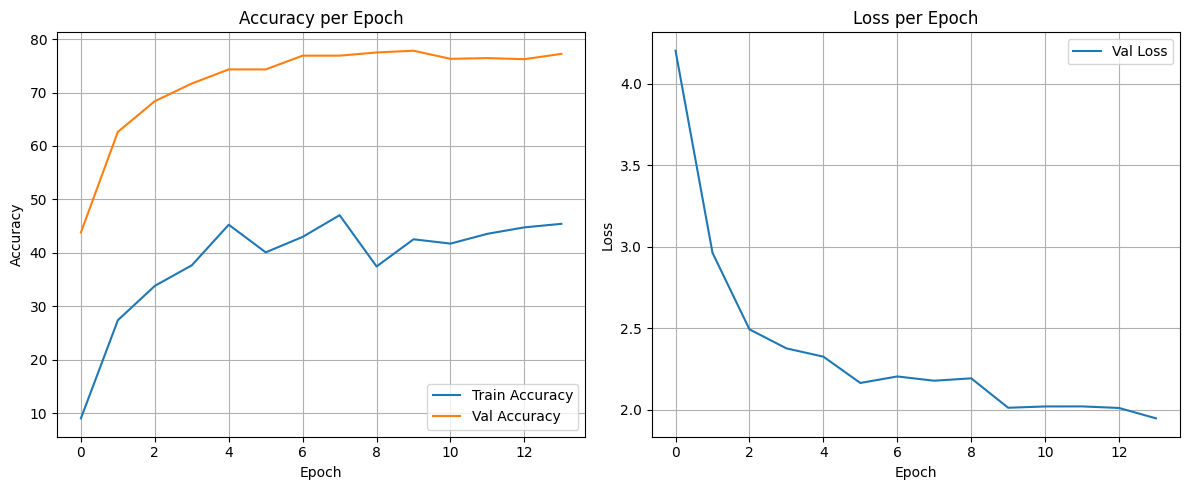

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
import os
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
from tqdm import tqdm

# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# Аугментации
IMG_SIZE = 128
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.3),
    A.HueSaturationValue(p=0.2),
    A.RandomCrop(height=IMG_SIZE, width=IMG_SIZE, p=0.1),
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.2),
    A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.2),
    A.MotionBlur(p=0.2),
    A.ElasticTransform(p=0.1),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
])

# Dataset
class CustomImageDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image, label

# Разделение
def get_stratified_datasets(root_dir, test_size=0.2):
    all_samples = []
    all_labels = []
    class_names = sorted(os.listdir(root_dir))
    for class_id in class_names:
        class_path = os.path.join(root_dir, class_id)
        if os.path.isdir(class_path):
            for fname in os.listdir(class_path):
                fpath = os.path.join(class_path, fname)
                all_samples.append((fpath, int(class_id)))
                all_labels.append(int(class_id))

    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    train_idx, val_idx = next(splitter.split(all_samples, all_labels))
    train_samples = [all_samples[i] for i in train_idx]
    val_samples = [all_samples[i] for i in val_idx]
    return train_samples, val_samples, class_names

train_samples, val_samples, class_names = get_stratified_datasets("data_split/train")

train_dataset = CustomImageDataset(train_samples, transform=train_transform)
val_dataset = CustomImageDataset(val_samples, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Class Weights
def get_class_weights(samples, num_classes):
    label_counts = Counter([label for _, label in samples])
    class_weights = [0] * num_classes
    total = sum(label_counts.values())
    for i in range(num_classes):
        class_weights[i] = total / (num_classes * label_counts[i])
    return torch.tensor(class_weights, dtype=torch.float)

class_weights = get_class_weights(train_samples, len(class_names)).to(device)

# Модель wide_resnet50_2
model = timm.create_model('wide_resnet50_2', pretrained=True, num_classes=len(class_names))
model = model.to(device)

# Размораживаем всё
for param in model.parameters():
    param.requires_grad = True

# Loss
criterion = nn.CrossEntropyLoss(label_smoothing=0.1, weight=class_weights)

# Mixup
def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Оптимизация и LR Scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

# Тренировка
best_val_acc = 0
early_stop_patience = 4
no_improve_epochs = 0
num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in tqdm(augmented_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    epoch_loss = running_loss / total

    # Валидация + TTA
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            tta_outputs = []
            for tta in [lambda x: x, lambda x: torch.flip(x, dims=[3]), lambda x: torch.flip(x, dims=[2])]:
                tta_inputs = tta(inputs)
                tta_outputs.append(model(tta_inputs))
            outputs = sum(tta_outputs) / len(tta_outputs)

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    scheduler.step(val_acc)

    print(f"Эпоха {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
    print("LR:", optimizer.param_groups[0]['lr'])

    train_accuracies.append(train_acc)
    val_losses.append(epoch_loss)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "generated_best_model_wide_resnet50_2.pth")
        print("Сохраняем модель")
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        print(f"Не было улучшения {no_improve_epochs} эпох подряд")

    if no_improve_epochs >= early_stop_patience:
        print("Сработала ранняя остановка")
        break

print(f"\n Лучшая validation accuracy: {best_val_acc:.2f}%")



# Графики loss и accuracy
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)

plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Результат немного хуже, чем без генератора. Значит, генератор недообучен или он слишком простой

# Лучшая модель (для загрузки на кагл)

В этом блоке приведен код обучения модели, которая показала себя лучше остальных, а также блок кода для загрузки файла на кагл

In [ ]:
import os
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
import random

import torchvision.transforms as transforms
from google.colab import files
import zipfile
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import cv2
import os
from PIL import Image
import random
from sklearn.model_selection import train_test_split
import shutil
from tqdm import tqdm


uploaded = files.upload()

In [ ]:
# Распаковываем архив
with zipfile.ZipFile("dl-2025-competition-1.zip", 'r') as zip_ref:
    zip_ref.extractall("data")  # распаковали в папку "data"

In [ ]:
train_dir = 'data/data/train'

# Список классов
class_names = sorted(os.listdir(train_dir))

# Считаем количество изображений в каждом классе
class_counts = {}
for cls in class_names:
    cls_path = os.path.join(train_dir, cls)
    image_files = os.listdir(cls_path)
    class_counts[cls] = len(image_files)

# Выводим топ-10 классов по числу картинок (если вдруг их много)
sorted_counts = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
sorted_class_counts = dict(sorted(class_counts.items(), key=lambda x: int(x[0])))



In [ ]:
# аугментации
# Параметры
IMG_SIZE = 128  # размер, подаваемый на вход модели

# Аугментации для train
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.3),
    A.HueSaturationValue(p=0.2),
    A.RandomCrop(height=IMG_SIZE, width=IMG_SIZE, p=0.1),
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.2),
    A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.2),
    A.MotionBlur(p=0.2),
    A.ElasticTransform(p=0.1),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2),
    A.Normalize(),
    ToTensorV2()
])

# Аугментации для валидации / теста (только приведение к виду)
val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
])

# Кастомный Dataset
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        for class_id in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_id)
            if os.path.isdir(class_path):
                for fname in os.listdir(class_path):
                    fpath = os.path.join(class_path, fname)
                    self.samples.append((fpath, int(class_id)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image, label



In [ ]:
def split_train_val(original_data_dir, new_base_dir, val_size=0.2):
    classes = os.listdir(original_data_dir)
    os.makedirs(f"{new_base_dir}/train", exist_ok=True)
    os.makedirs(f"{new_base_dir}/val", exist_ok=True)

    for cls in tqdm(classes):
        cls_path = os.path.join(original_data_dir, cls)
        images = os.listdir(cls_path)
        train_imgs, val_imgs = train_test_split(images, test_size=val_size, random_state=42)

        os.makedirs(os.path.join(new_base_dir, "train", cls), exist_ok=True)
        os.makedirs(os.path.join(new_base_dir, "val", cls), exist_ok=True)

        for img in train_imgs:
            shutil.copy(os.path.join(cls_path, img), os.path.join(new_base_dir, "train", cls, img))
        for img in val_imgs:
            shutil.copy(os.path.join(cls_path, img), os.path.join(new_base_dir, "val", cls, img))

# Вызов
split_train_val("data/data/train", "data_split", val_size=0.2)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
import os
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
from tqdm import tqdm

# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# Аугментации
IMG_SIZE = 128
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.3),
    A.HueSaturationValue(p=0.2),
    A.RandomCrop(height=IMG_SIZE, width=IMG_SIZE, p=0.1),
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.2),
    A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.2),
    A.MotionBlur(p=0.2),
    A.ElasticTransform(p=0.1),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
])

# Dataset
class CustomImageDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image, label

# Разделение
def get_stratified_datasets(root_dir, test_size=0.2):
    all_samples = []
    all_labels = []
    class_names = sorted(os.listdir(root_dir))
    for class_id in class_names:
        class_path = os.path.join(root_dir, class_id)
        if os.path.isdir(class_path):
            for fname in os.listdir(class_path):
                fpath = os.path.join(class_path, fname)
                all_samples.append((fpath, int(class_id)))
                all_labels.append(int(class_id))

    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    train_idx, val_idx = next(splitter.split(all_samples, all_labels))
    train_samples = [all_samples[i] for i in train_idx]
    val_samples = [all_samples[i] for i in val_idx]
    return train_samples, val_samples, class_names

train_samples, val_samples, class_names = get_stratified_datasets("data_split/train")

train_dataset = CustomImageDataset(train_samples, transform=train_transform)
val_dataset = CustomImageDataset(val_samples, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Class Weights
def get_class_weights(samples, num_classes):
    label_counts = Counter([label for _, label in samples])
    class_weights = [0] * num_classes
    total = sum(label_counts.values())
    for i in range(num_classes):
        class_weights[i] = total / (num_classes * label_counts[i])
    return torch.tensor(class_weights, dtype=torch.float)

class_weights = get_class_weights(train_samples, len(class_names)).to(device)

# Модель wide_resnet50_2
model = timm.create_model('wide_resnet50_2', pretrained=True, num_classes=len(class_names))
model = model.to(device)

# Размораживаем всё
for param in model.parameters():
    param.requires_grad = True

# Loss
criterion = nn.CrossEntropyLoss(label_smoothing=0.1, weight=class_weights)

# Mixup
def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Оптимизация и LR Scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

# Тренировка
best_val_acc = 0
early_stop_patience = 4
no_improve_epochs = 0
num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.4)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    epoch_loss = running_loss / total

    # Валидация + TTA
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            tta_outputs = []
            for tta in [lambda x: x, lambda x: torch.flip(x, dims=[3]), lambda x: torch.flip(x, dims=[2])]:
                tta_inputs = tta(inputs)
                tta_outputs.append(model(tta_inputs))
            outputs = sum(tta_outputs) / len(tta_outputs)

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
    print("Current LR:", optimizer.param_groups[0]['lr'])

    train_accuracies.append(train_acc)
    val_losses.append(epoch_loss)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model_wide_resnet50_2.pth")
        print("✅ Model saved!")
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        print(f"❌ No improvement for {no_improve_epochs} epoch(s)")

    if no_improve_epochs >= early_stop_patience:
        print("🛑 Early stopping triggered.")
        break

print(f"\n📈 Best Validation Accuracy: {best_val_acc:.2f}%")



# Графики loss и accuracy
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)

plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

блок для загрузки на кагл:

In [ ]:
import pandas as pd
import torch
import os
import cv2
import numpy as np
import timm
from tqdm import tqdm
from albumentations.pytorch import ToTensorV2
import albumentations as A


device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")


# Пути
test_dir = "data/data/test"
sample_path = "data/sample_submission.csv"

# Размер изображений
IMG_SIZE = 128

# Трансформации
val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
])

# Загрузка модели
model = timm.create_model('wide_resnet50_2', pretrained=True, num_classes=len(class_names))
model.load_state_dict(torch.load("best_model_wide_resnet50_2.pth", map_location=device))
model.to(device)
model.eval()

# Загрузка sample_submission
submission = pd.read_csv(sample_path)

# Сортируем файлы по числовому значению имени файла
image_ids = sorted(os.listdir(test_dir), key=lambda x: int(os.path.splitext(x)[0]))

# Предсказания
preds = []
for img_name in tqdm(image_ids, desc="Predicting"):
    img_path = os.path.join(test_dir, img_name)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = val_transform(image=image)['image'].unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(output, dim=1).item()
        preds.append(pred)

# Обновляем колонку Target
submission['target'] = preds

# Сохраняем
submission.to_csv("submission.csv", index=False)
print("✅ submission.csv готова к загрузке на Kaggle!")


Predicting: 100%|██████████| 3878/3878 [00:38<00:00, 100.61it/s]

✅ submission.csv готова к загрузке на Kaggle!
